### Downloading the dataset

In [ ]:
!nvidia-smi

Thu Apr  8 02:28:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import shutil
import os
try:
    shutil.rmtree("inaturalist_12K")
except:
    pass

try:
    os.remove("nature_12K.zip")
except:
    pass

try:
    shutil.rmtree("wandb")
except:
    pass

In [ ]:
!gdown https://drive.google.com/uc?id=1AWK5fe-W29Bry_GytbDMqoFwQXVom56s

Downloading...
From: https://drive.google.com/uc?id=1AWK5fe-W29Bry_GytbDMqoFwQXVom56s
To: /content/nature_12K.zip
3.82GB [01:05, 58.0MB/s]


In [ ]:
%%capture
!unzip "/content/nature_12K.zip"

In [ ]:
%%capture
! pip install wandb

In [ ]:
!find . -name "*.DS_Store" -type f -delete

### Importing libraries

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import keras
from keras.layers import Conv2D , MaxPool2D , Flatten , Dropout, Dense, Activation, BatchNormalization
from keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import Sequential, load_model
import random
import wandb
import shutil
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from wandb.keras import WandbCallback

### Exploring the data

In [ ]:
# list of class names
temp = os.listdir("inaturalist_12K/train")
class_names = [name for name in temp if name != ".DS_Store"]
print("The names of the classes are:")
print(class_names)

num_classes = len(class_names)
print(f"Number of classes = {num_classes}\n")

M = 0
M_test = 0

for each_class in class_names:
    train_images = os.listdir("inaturalist_12K/train/"+each_class)
    test_images = os.listdir("inaturalist_12K/val/"+each_class)
    filtered_train_images = list(filter(lambda x: x!=".DS_Store", train_images))
    filtered_test_images = list(filter(lambda x: x!=".DS_Store", test_images))
    M = M + len(filtered_train_images)
    M_test = M_test + len(filtered_test_images)

print(f"Total number of training images = {M}")
print(f"Total number of test images = {M_test}\n")

The names of the classes are:
['Amphibia', 'Plantae', 'Fungi', 'Reptilia', 'Animalia', 'Arachnida', 'Aves', 'Mollusca', 'Insecta', 'Mammalia']
Number of classes = 10

Total number of training images = 9999
Total number of test images = 2000



In [ ]:
# # Average image shape
# height = 0
# width = 0
# for each_class in class_names:
#     images = os.listdir("inaturalist_12K/train/"+each_class)
#     filtered_images = filter(lambda x: x!=".DS_Store", images)
#     for image_name in filtered_images:
#         image = plt.imread("inaturalist_12K/train/"+each_class+"/"+image_name)
#         height += image.shape[0]
#         width += image.shape[1]

In [ ]:
# height /= M
# width /= M

# print(f"The average image height is {height}")
# print(f"The average image width is {width}")

In [ ]:
input_image_shape = (224, 224, 3)

### Creating validation set

In [ ]:
validation_split_fraction = 0.1

try:
    shutil.rmtree("inaturalist_12K/validation/")
except:
    pass
    
os.mkdir("inaturalist_12K/validation/")

for each_class in class_names:
    os.mkdir("inaturalist_12K/validation/"+each_class)
    train_images = os.listdir("inaturalist_12K/train/"+each_class)
    filtered_train_images = list(filter(lambda x: x!=".DS_Store", train_images))
    count = len(filtered_train_images)
    random.shuffle(filtered_train_images) # Shuffle the training images

    validation_images = filtered_train_images[:round(validation_split_fraction*count)]

    for im in validation_images:
        shutil.move("inaturalist_12K/train/"+each_class+"/"+im, "inaturalist_12K/validation/"+each_class+"/"+im)

### Set up the training, validation and test generators

In [ ]:
def make_generators(train_batch_size, data_aug):
    if data_aug:
        train_datagen = ImageDataGenerator(rescale=1./255,
                                        height_shift_range=0.2,
                                        width_shift_range=0.2,
                                        horizontal_flip=True,
                                        zoom_range=0.2,
                                        fill_mode="nearest")
    else:
        train_datagen = ImageDataGenerator(rescale=1./255)

    val_datagen = ImageDataGenerator(rescale=1./255)

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        'inaturalist_12K/train',
        target_size=input_image_shape[:2],
        color_mode="rgb",
        batch_size=train_batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=42)

    # batch_size for validation and test generator should perfectly divide the total number of examples
    validation_generator = val_datagen.flow_from_directory(
        'inaturalist_12K/validation',
        target_size=input_image_shape[:2],
        color_mode="rgb",
        batch_size=100,
        class_mode='categorical',
        shuffle=True,
        seed=42)

    test_generator = test_datagen.flow_from_directory(
        'inaturalist_12K/val',
        target_size=input_image_shape[:2],
        color_mode="rgb",
        batch_size=100,
        class_mode=None,
        shuffle=False,
        seed=42)
    
    return train_generator, validation_generator, test_generator

### Building the model

In [ ]:
def define_model(activation_function_conv, activation_function_dense, num_filters, shape_of_filters_conv, shape_of_filters_pool, batch_norm_use, fc_layer, dropout):
    model = Sequential()
    model.add(Conv2D(num_filters[0], shape_of_filters_conv[0], input_shape=input_image_shape))
    if batch_norm_use:
        model.add(BatchNormalization())
    model.add(Activation(activation_function_conv[0]))
    model.add(MaxPool2D(pool_size=shape_of_filters_pool[0], strides = (2, 2)))

    for i in range(1, 5):
        model.add(Conv2D(num_filters[i], shape_of_filters_conv[i]))
        if batch_norm_use:
            model.add(BatchNormalization())
        model.add(Activation(activation_function_conv[i]))
        model.add(MaxPool2D(pool_size=shape_of_filters_pool[i], strides = (2, 2)))

    model.add(Flatten()) # The flatten layer is essential to convert the feature map into a column vector
    model.add(Dense(fc_layer, activation=activation_function_dense))
    model.add(Dropout(dropout)) # For regularization
    model.add(Dense(10, activation="softmax"))
    return model

In [ ]:
def train_validate_model(train_batch_size, data_aug, activation_function_conv, activation_function_dense, num_filters, shape_of_filters_conv, shape_of_filters_pool, batch_norm_use, fc_layer, dropout):
    # Create the data generators
    train_generator, validation_generator, test_generator = make_generators(train_batch_size, data_aug)
    
    # Define the model
    model = define_model(activation_function_conv, activation_function_dense, num_filters, shape_of_filters_conv, shape_of_filters_pool, batch_norm_use, fc_layer, dropout)
    print(model.summary())

    TRAIN_STEP_SIZE = train_generator.n//train_generator.batch_size
    VALIDATION_STEP_SIZE = validation_generator.n//validation_generator.batch_size

    model.compile(optimizer=Adam(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

    # Early Stopping callback
    earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

    # To save the model with best validation accuracy
    mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

    history = model.fit(train_generator,
                        steps_per_epoch = TRAIN_STEP_SIZE,
                        validation_data = validation_generator,
                        validation_steps = VALIDATION_STEP_SIZE,
                        epochs=20, 
                        callbacks=[earlyStopping, mc],
                        verbose=2)
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    
    return history

In [ ]:
def train_validate_model_wandb():
    # Default values for hyper-parameters
    config_defaults = {
        "data_aug": True,
        "train_batch_size": 128,
        "batch_norm_use": True,
        "dropout": 0,
        "num_filters": [16, 32, 64, 128, 256],
        "fc_layer": 256,
        "shape_of_filters_conv": [(3, 3), (3, 3), (3, 3), (3, 3), (3, 3)]
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # Local variables, values obtained from wandb config
    num_filters = config.num_filters
    data_aug = config.data_aug
    train_batch_size = config.train_batch_size
    batch_norm_use = config.batch_norm_use
    dropout = config.dropout
    fc_layer = config.fc_layer
    shape_of_filters_conv = config.shape_of_filters_conv
    
    # Display the hyperparameters
    run_name = "aug_{}_bs_{}_bn_{}_drop_{}_fc_{}_fil_{}_shape_{}".format(data_aug, train_batch_size, batch_norm_use, dropout, fc_layer, num_filters, shape_of_filters_conv)
    print(run_name)

    # Create the data generators
    train_generator, validation_generator, test_generator = make_generators(train_batch_size, data_aug)
    
    # Define the model
    model = define_model(activation_function_conv, activation_function_dense, num_filters, shape_of_filters_conv, shape_of_filters_pool, batch_norm_use, fc_layer, dropout)
    print(model.count_params())

    TRAIN_STEP_SIZE = train_generator.n//train_generator.batch_size
    VALIDATION_STEP_SIZE = validation_generator.n//validation_generator.batch_size

    model.compile(optimizer=Adam(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

    # Early Stopping callback
    earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')

    # To save the model with best validation accuracy
    mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

    history = model.fit(train_generator,
                        steps_per_epoch = TRAIN_STEP_SIZE,
                        validation_data = validation_generator,
                        validation_steps = VALIDATION_STEP_SIZE,
                        epochs=10, 
                        callbacks=[WandbCallback(data_type="image", generator=validation_generator), earlyStopping, mc],
                        verbose=2)
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    # Meaningful name for the run
    wandb.run.name = run_name
    wandb.run.save()
    wandb.run.finish()
    return history

### Hyperparameter Search using WandB

In [ ]:
activation_function_conv = ["relu", "relu", "relu", "relu", "relu"]
activation_function_dense = "relu"
shape_of_filters_pool = [(2, 2), (2, 2), (2, 2), (2, 2), (2, 2)]

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: rz78ffyq
Sweep URL: https://wandb.ai/ee17b154tony/dl_assignment_2/sweeps/rz78ffyq


wandb: Agent Starting Run: le672l21 with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: True
wandb: 	dropout: 0
wandb: 	fc_layer: 128
wandb: 	num_filters: [32, 32, 32, 32, 32]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
wandb: 	train_batch_size: 128
wandb: Currently logged in as: ee17b154tony (use `wandb login --relogin` to force relogin)


aug_True_bs_128_bn_True_drop_0_fc_128_fil_[32, 32, 32, 32, 32]_shape_[[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
113674
Epoch 1/20
70/70 - 241s - loss: 2.3107 - accuracy: 0.1637 - val_loss: 2.3191 - val_accuracy: 0.1000
Epoch 2/20
70/70 - 206s - loss: 2.1509 - accuracy: 0.2303 - val_loss: 2.3774 - val_accuracy: 0.1000
Epoch 3/20
70/70 - 198s - loss: 2.1052 - accuracy: 0.2436 - val_loss: 2.4158 - val_accuracy: 0.0990
Epoch 4/20
70/70 - 197s - loss: 2.0645 - accuracy: 0.2605 - val_loss: 2.4560 - val_accuracy: 0.1100
Epoch 5/20
70/70 - 197s - loss: 2.0341 - accuracy: 0.2766 - val_loss: 2.4483 - val_accuracy: 0.1140
Epoch 6/20
70/70 - 197s - loss: 2.0099 - accuracy: 0.2855 - val_loss: 2.3130 - val_accuracy: 0.1460
Epoch 7/20
70/70 - 197s - loss: 1.9871 - accuracy: 0.2961 - val_loss: 2.1686 - val_accuracy: 0.2270
Epoch 8/20
70/70 - 198s - loss: 1.9726 - accuracy: 0.3

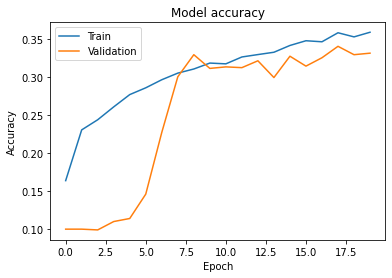

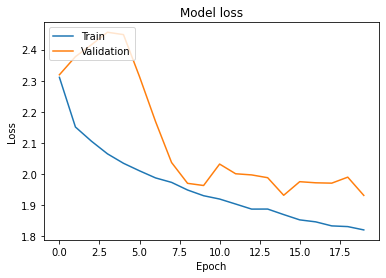

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: eewwcvg7 with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0
wandb: 	fc_layer: 256
wandb: 	num_filters: [16, 32, 64, 128, 256]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
wandb: 	train_batch_size: 256


aug_True_bs_256_bn_False_drop_0_fc_256_fil_[16, 32, 64, 128, 256]_shape_[[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
2099370
Epoch 1/20
35/35 - 196s - loss: 2.2942 - accuracy: 0.1137 - val_loss: 2.2698 - val_accuracy: 0.1700
Epoch 2/20
35/35 - 198s - loss: 2.2484 - accuracy: 0.1671 - val_loss: 2.2145 - val_accuracy: 0.1770
Epoch 3/20
35/35 - 200s - loss: 2.1772 - accuracy: 0.2027 - val_loss: 2.1353 - val_accuracy: 0.2290
Epoch 4/20
35/35 - 195s - loss: 2.1358 - accuracy: 0.2259 - val_loss: 2.1141 - val_accuracy: 0.2500
Epoch 5/20
35/35 - 194s - loss: 2.1039 - accuracy: 0.2398 - val_loss: 2.0722 - val_accuracy: 0.2640
Epoch 6/20
35/35 - 198s - loss: 2.0818 - accuracy: 0.2466 - val_loss: 2.0690 - val_accuracy: 0.2750
Epoch 7/20
35/35 - 194s - loss: 2.0577 - accuracy: 0.2624 - val_loss: 2.0480 - val_accuracy: 0.2780
Epoch 8/20
35/35 - 198s - loss: 2.0459 - accuracy:

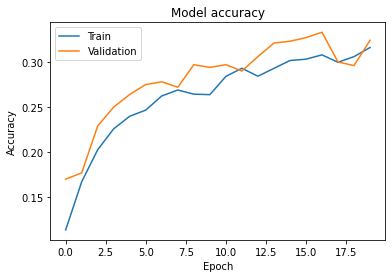

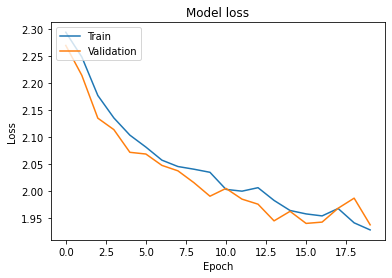

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: xy2m946d with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: True
wandb: 	dropout: 0.2
wandb: 	fc_layer: 512
wandb: 	num_filters: [16, 32, 64, 128, 256]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
wandb: 	train_batch_size: 256


aug_True_bs_256_bn_True_drop_0.2_fc_512_fil_[16, 32, 64, 128, 256]_shape_[[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
2366314
Epoch 1/20
35/35 - 196s - loss: 2.2955 - accuracy: 0.2045 - val_loss: 2.3257 - val_accuracy: 0.1150
Epoch 2/20
35/35 - 194s - loss: 2.0775 - accuracy: 0.2598 - val_loss: 2.3891 - val_accuracy: 0.0940
Epoch 3/20
35/35 - 195s - loss: 2.0193 - accuracy: 0.2767 - val_loss: 2.4930 - val_accuracy: 0.1000
Epoch 4/20
35/35 - 196s - loss: 1.9823 - accuracy: 0.3014 - val_loss: 2.4630 - val_accuracy: 0.1310
Epoch 5/20
35/35 - 196s - loss: 1.9411 - accuracy: 0.3139 - val_loss: 2.4962 - val_accuracy: 0.1440
Epoch 6/20
35/35 - 198s - loss: 1.9239 - accuracy: 0.3189 - val_loss: 2.4118 - val_accuracy: 0.1460
Epoch 7/20
35/35 - 197s - loss: 1.9034 - accuracy: 0.3281 - val_loss: 2.4391 - val_accuracy: 0.1580
Epoch 8/20
35/35 - 195s - loss: 1.8661 - accuracy

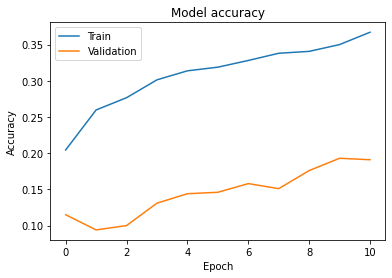

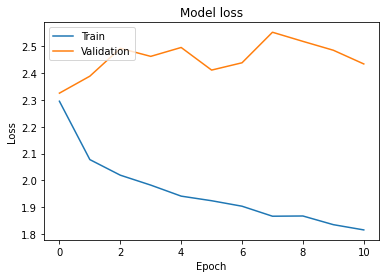

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 67wqxzgd with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0.1
wandb: 	fc_layer: 256
wandb: 	num_filters: [256, 128, 64, 32, 16]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_False_drop_0.1_fc_256_fil_[256, 128, 64, 32, 16]_shape_[[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
471546
Epoch 1/20


Run 67wqxzgd errored: ResourceExhaustedError()
wandb: ERROR Run 67wqxzgd errored: ResourceExhaustedError()
wandb: Agent Starting Run: ebptnkbb with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: False
wandb: 	dropout: 0
wandb: 	fc_layer: 128
wandb: 	num_filters: [16, 32, 64, 128, 256]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 256


aug_False_bs_256_bn_True_drop_0_fc_128_fil_[16, 32, 64, 128, 256]_shape_[[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
1215210
Epoch 1/20
35/35 - 114s - loss: 2.2424 - accuracy: 0.2191 - val_loss: 2.3075 - val_accuracy: 0.1020
Epoch 2/20
35/35 - 112s - loss: 1.9398 - accuracy: 0.3164 - val_loss: 2.3421 - val_accuracy: 0.1000
Epoch 3/20
35/35 - 111s - loss: 1.8227 - accuracy: 0.3607 - val_loss: 2.4092 - val_accuracy: 0.1010
Epoch 4/20
35/35 - 112s - loss: 1.7047 - accuracy: 0.4065 - val_loss: 2.4274 - val_accuracy: 0.1080
Epoch 5/20
35/35 - 112s - loss: 1.5930 - accuracy: 0.4599 - val_loss: 2.5114 - val_accuracy: 0.1100
Epoch 6/20
35/35 - 113s - loss: 1.4919 - accuracy: 0.5039 - val_loss: 2.5492 - val_accuracy: 0.1180
Epoch 7/20
35/35 - 112s - loss: 1.3796 - accuracy: 0.5472 - val_loss: 2.4893 - val_accuracy: 0.1180
Epoch 8/20
35/35 - 112s - loss: 1.2728 - accuracy:

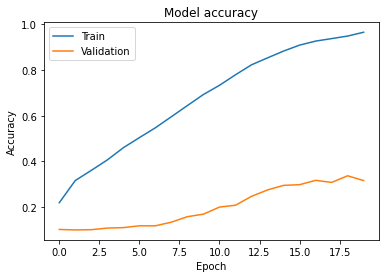

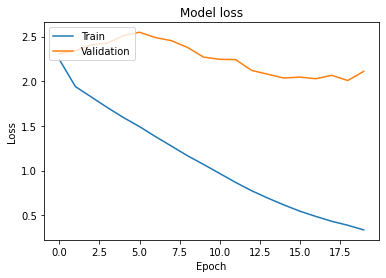

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: muoxykfd with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0.1
wandb: 	fc_layer: 512
wandb: 	num_filters: [32, 64, 128, 256, 512]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_False_drop_0.1_fc_512_fil_[32, 64, 128, 256, 512]_shape_[[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
8127818
Epoch 1/20
70/70 - 201s - loss: 2.2323 - accuracy: 0.1717 - val_loss: 2.1515 - val_accuracy: 0.2240
Epoch 2/20
70/70 - 196s - loss: 2.1258 - accuracy: 0.2226 - val_loss: 2.0595 - val_accuracy: 0.2600
Epoch 3/20
70/70 - 196s - loss: 2.0763 - accuracy: 0.2545 - val_loss: 2.0617 - val_accuracy: 0.2640
Epoch 4/20
70/70 - 192s - loss: 2.0449 - accuracy: 0.2647 - val_loss: 1.9936 - val_accuracy: 0.2950
Epoch 5/20
70/70 - 196s - loss: 2.0191 - accuracy: 0.2789 - val_loss: 1.9675 - val_accuracy: 0.2950
Epoch 6/20
70/70 - 195s - loss: 1.9922 - accuracy: 0.2932 - val_loss: 1.9522 - val_accuracy: 0.3120
Epoch 7/20
70/70 - 196s - loss: 1.9652 - accuracy: 0.3074 - val_loss: 1.9216 - val_accuracy: 0.3380
Epoch 8/20
70/70 - 195s - loss: 1.9408 - accura

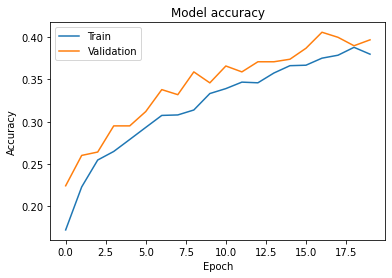

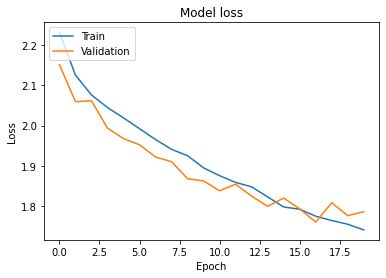

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: uly61d0a with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: False
wandb: 	dropout: 0.1
wandb: 	fc_layer: 256
wandb: 	num_filters: [32, 32, 32, 32, 32]
wandb: 	shape_of_filters_conv: [[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 256


aug_False_bs_256_bn_True_drop_0.1_fc_256_fil_[32, 32, 32, 32, 32]_shape_[[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
192650
Epoch 1/20
35/35 - 117s - loss: 2.4947 - accuracy: 0.1195 - val_loss: 2.3070 - val_accuracy: 0.1080
Epoch 2/20
35/35 - 114s - loss: 2.2347 - accuracy: 0.1967 - val_loss: 2.3247 - val_accuracy: 0.1040
Epoch 3/20
35/35 - 113s - loss: 2.1226 - accuracy: 0.2456 - val_loss: 2.3527 - val_accuracy: 0.1170
Epoch 4/20
35/35 - 113s - loss: 2.0451 - accuracy: 0.2690 - val_loss: 2.3741 - val_accuracy: 0.1240
Epoch 5/20
35/35 - 113s - loss: 1.9857 - accuracy: 0.2985 - val_loss: 2.4106 - val_accuracy: 0.1080
Epoch 6/20
35/35 - 112s - loss: 1.9485 - accuracy: 0.3165 - val_loss: 2.4312 - val_accuracy: 0.1330
Epoch 7/20
35/35 - 112s - loss: 1.9027 - accuracy: 0.3330 - val_loss: 2.4511 - val_accuracy: 0.1200
Epoch 8/20
35/35 - 114s - loss: 1.8571 - accuracy: 

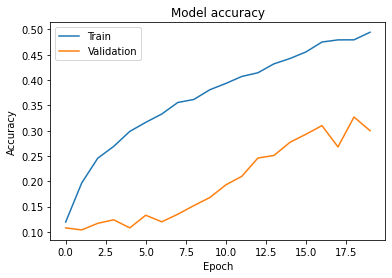

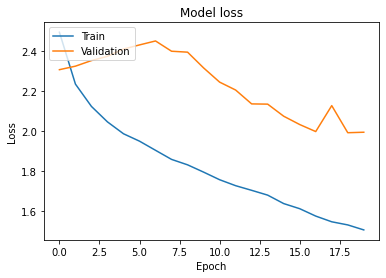

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 8rd8p73m with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0
wandb: 	fc_layer: 512
wandb: 	num_filters: [256, 128, 64, 32, 16]
wandb: 	shape_of_filters_conv: [[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 256


aug_True_bs_256_bn_False_drop_0_fc_512_fil_[256, 128, 64, 32, 16]_shape_[[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
1090810
Epoch 1/20


In [ ]:
sweep_config = {
  "name": "Sweep 2 CS6910 Assignment 2 - Part A",
  "metric": {
      "name":"val_accuracy",
      "goal": "maximize"
  },
  "method": "random",
  "parameters": {
        "data_aug": {
            "values": [True, False]
        },
        "train_batch_size": {
            "values": [128, 256]
        },
        "batch_norm_use": {
            "values": [True, False]
        },
        "dropout": {
            "values": [0, 0.2, 0.1]
        },
        "num_filters": {
            "values": [[16, 32, 64, 128, 256], [32, 64, 128, 256, 512], [32, 32, 32, 32, 32],
                       [256, 128, 64, 32, 16]]
        },
        "fc_layer": {
            "values": [128, 256, 512]
        },
        "shape_of_filters_conv": {
            "values": [[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3)],
                       [(7, 7), (5, 5), (3, 3), (3, 3), (3, 3)],
                       [(3, 3), (3, 3), (3, 3), (5, 5), (7, 7)]]
        }
    }
}
#hyqwrmx5
sweep_id = wandb.sweep(sweep_config, entity="ee17b154tony", project="dl_assignment_2")
wandb.agent(sweep_id, train_validate_model_wandb, count=100)

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: hobtifap
Sweep URL: https://wandb.ai/ee17b154tony/dl_assignment_2/sweeps/hobtifap


wandb: Agent Starting Run: lmlv2wot with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: False
wandb: 	dropout: 0
wandb: 	fc_layer: 256
wandb: 	num_filters: [32, 32, 32, 32, 32]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 256
wandb: Currently logged in as: ee17b154tony (use `wandb login --relogin` to force relogin)


aug_False_bs_256_bn_True_drop_0_fc_256_fil_[32, 32, 32, 32, 32]_shape_[[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
246154
Epoch 1/20
35/35 - 168s - loss: 2.3835 - accuracy: 0.1565 - val_loss: 2.3151 - val_accuracy: 0.0900
Epoch 2/20
35/35 - 128s - loss: 2.1201 - accuracy: 0.2434 - val_loss: 2.3604 - val_accuracy: 0.0930
Epoch 3/20
35/35 - 123s - loss: 2.0240 - accuracy: 0.2842 - val_loss: 2.4011 - val_accuracy: 0.0990
Epoch 4/20
35/35 - 123s - loss: 1.9501 - accuracy: 0.3171 - val_loss: 2.4151 - val_accuracy: 0.1000
Epoch 5/20
35/35 - 121s - loss: 1.8967 - accuracy: 0.3379 - val_loss: 2.4506 - val_accuracy: 0.1020
Epoch 6/20
35/35 - 122s - loss: 1.8515 - accuracy: 0.3535 - val_loss: 2.4391 - val_accuracy: 0.1170
Epoch 7/20
35/35 - 120s - loss: 1.8064 - accuracy: 0.3744 - val_loss: 2.4452 - val_accuracy: 0.1120
Epoch 8/20
35/35 - 121s - loss: 1.7710 - accuracy: 0.

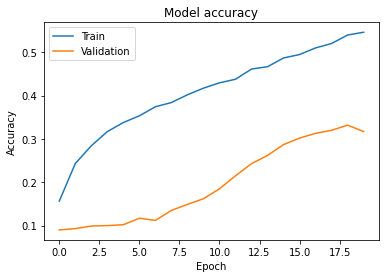

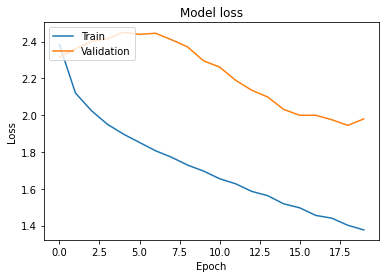

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: ye36vrkr with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: False
wandb: 	dropout: 0.2
wandb: 	fc_layer: 512
wandb: 	num_filters: [16, 32, 64, 128, 256]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
wandb: 	train_batch_size: 256


aug_False_bs_256_bn_True_drop_0.2_fc_512_fil_[16, 32, 64, 128, 256]_shape_[[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
2366314
Epoch 1/20
35/35 - 126s - loss: 2.2202 - accuracy: 0.2298 - val_loss: 2.3161 - val_accuracy: 0.1020
Epoch 2/20
35/35 - 123s - loss: 1.8883 - accuracy: 0.3432 - val_loss: 2.3469 - val_accuracy: 0.1000
Epoch 3/20
35/35 - 123s - loss: 1.7167 - accuracy: 0.4070 - val_loss: 2.3833 - val_accuracy: 0.1050
Epoch 4/20
35/35 - 123s - loss: 1.5172 - accuracy: 0.4908 - val_loss: 2.4764 - val_accuracy: 0.1120
Epoch 5/20
35/35 - 123s - loss: 1.3114 - accuracy: 0.5763 - val_loss: 2.6333 - val_accuracy: 0.1020
Epoch 6/20
35/35 - 125s - loss: 1.1004 - accuracy: 0.6667 - val_loss: 2.7626 - val_accuracy: 0.1000
Epoch 7/20
35/35 - 123s - loss: 0.8781 - accuracy: 0.7567 - val_loss: 2.8280 - val_accuracy: 0.1030
Epoch 8/20
35/35 - 122s - loss: 0.6885 - accurac

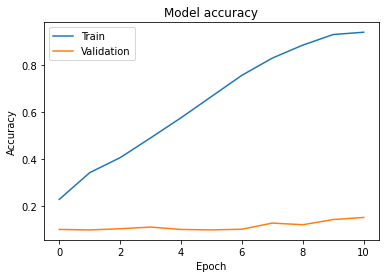

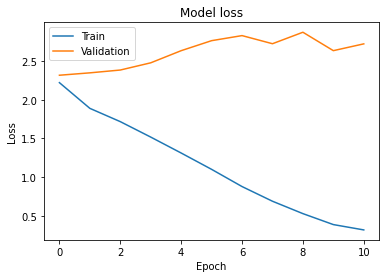

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: s8hvm8gg with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0.2
wandb: 	fc_layer: 512
wandb: 	num_filters: [32, 32, 32, 32, 32]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_False_drop_0.2_fc_512_fil_[32, 32, 32, 32, 32]_shape_[[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
166410
Epoch 1/20
70/70 - 217s - loss: 2.3010 - accuracy: 0.1131 - val_loss: 2.2948 - val_accuracy: 0.1580
Epoch 2/20
70/70 - 213s - loss: 2.2774 - accuracy: 0.1487 - val_loss: 2.2436 - val_accuracy: 0.1590
Epoch 3/20
70/70 - 212s - loss: 2.2247 - accuracy: 0.1778 - val_loss: 2.1819 - val_accuracy: 0.1980
Epoch 4/20
70/70 - 211s - loss: 2.1644 - accuracy: 0.2048 - val_loss: 2.1402 - val_accuracy: 0.2300
Epoch 5/20
70/70 - 213s - loss: 2.1569 - accuracy: 0.2079 - val_loss: 2.1515 - val_accuracy: 0.2200
Epoch 6/20
Epoch 7/20
70/70 - 218s - loss: 2.1116 - accuracy: 0.2301 - val_loss: 2.0890 - val_accuracy: 0.2540
Epoch 8/20
70/70 - 218s - loss: 2.0961 - accuracy: 0.2394 - val_loss: 2.0839 - val_accuracy: 0.2420
Epoch 9/20
70/70 - 218s - loss: 2.0882 -

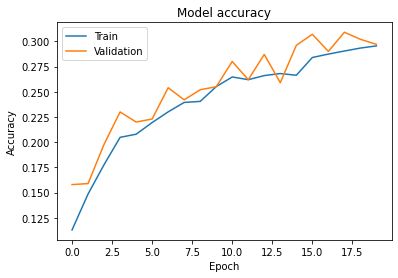

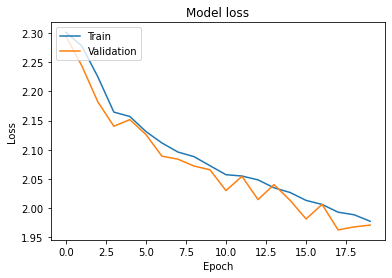

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 39h2j8kh with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: False
wandb: 	dropout: 0.2
wandb: 	fc_layer: 256
wandb: 	num_filters: [256, 128, 64, 32, 16]
wandb: 	shape_of_filters_conv: [[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_False_bs_128_bn_False_drop_0.2_fc_256_fil_[256, 128, 64, 32, 16]_shape_[[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
1022458
Epoch 1/20


Run 39h2j8kh errored: ResourceExhaustedError()
wandb: ERROR Run 39h2j8kh errored: ResourceExhaustedError()
wandb: Agent Starting Run: 2y8hyye9 with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: False
wandb: 	dropout: 0.1
wandb: 	fc_layer: 256
wandb: 	num_filters: [32, 64, 128, 256, 512]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 256


aug_False_bs_256_bn_True_drop_0.1_fc_256_fil_[32, 64, 128, 256, 512]_shape_[[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
4852170
Epoch 1/20
35/35 - 130s - loss: 2.3456 - accuracy: 0.2204 - val_loss: 2.3183 - val_accuracy: 0.1010
Epoch 2/20
35/35 - 126s - loss: 1.9052 - accuracy: 0.3326 - val_loss: 2.3695 - val_accuracy: 0.1120
Epoch 3/20
35/35 - 128s - loss: 1.7725 - accuracy: 0.3879 - val_loss: 2.4521 - val_accuracy: 0.1050
Epoch 4/20
35/35 - 126s - loss: 1.6149 - accuracy: 0.4453 - val_loss: 2.4122 - val_accuracy: 0.1060
Epoch 5/20
35/35 - 128s - loss: 1.4664 - accuracy: 0.5061 - val_loss: 2.5000 - val_accuracy: 0.1190
Epoch 6/20
35/35 - 129s - loss: 1.3071 - accuracy: 0.5759 - val_loss: 2.5840 - val_accuracy: 0.1170
Epoch 7/20
35/35 - 132s - loss: 1.1427 - accuracy: 0.6407 - val_loss: 2.5234 - val_accuracy: 0.1080
Epoch 8/20
35/35 - 132s - loss: 0.9707 - accura

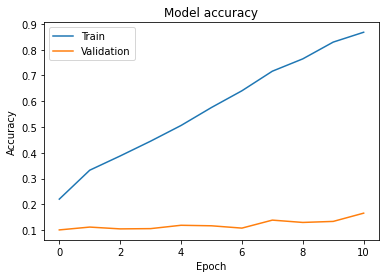

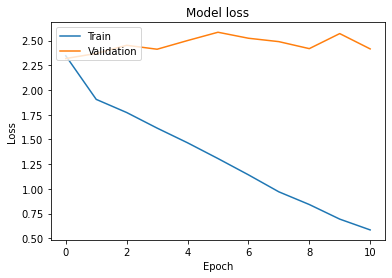

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 17tu8pld with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: False
wandb: 	dropout: 0.1
wandb: 	fc_layer: 128
wandb: 	num_filters: [16, 32, 64, 128, 256]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_False_bs_128_bn_False_drop_0.1_fc_128_fil_[16, 32, 64, 128, 256]_shape_[[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
1213226
Epoch 1/20
70/70 - 133s - loss: 2.2790 - accuracy: 0.1304 - val_loss: 2.2129 - val_accuracy: 0.1920
Epoch 2/20
70/70 - 130s - loss: 2.1269 - accuracy: 0.2327 - val_loss: 2.1118 - val_accuracy: 0.2530
Epoch 3/20
70/70 - 129s - loss: 2.0425 - accuracy: 0.2734 - val_loss: 2.0257 - val_accuracy: 0.2890
Epoch 4/20
70/70 - 131s - loss: 1.9932 - accuracy: 0.2915 - val_loss: 1.9778 - val_accuracy: 0.3060
Epoch 5/20
70/70 - 132s - loss: 1.9606 - accuracy: 0.3103 - val_loss: 1.9633 - val_accuracy: 0.3150
Epoch 6/20
70/70 - 132s - loss: 1.9393 - accuracy: 0.3162 - val_loss: 1.9416 - val_accuracy: 0.3140
Epoch 7/20
70/70 - 133s - loss: 1.9168 - accuracy: 0.3267 - val_loss: 1.9299 - val_accuracy: 0.3270
Epoch 8/20
70/70 - 133s - loss: 1.9028 - accura

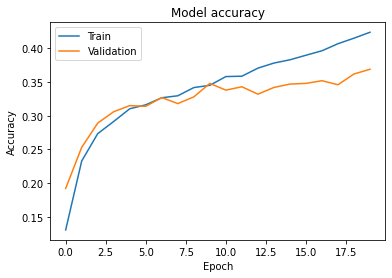

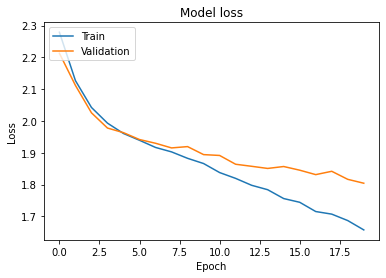

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: r4ywz28s with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: False
wandb: 	dropout: 0.2
wandb: 	fc_layer: 256
wandb: 	num_filters: [32, 64, 128, 256, 512]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
wandb: 	train_batch_size: 128


aug_False_bs_128_bn_True_drop_0.2_fc_256_fil_[32, 64, 128, 256, 512]_shape_[[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
7866826
Epoch 1/20
70/70 - 135s - loss: 2.1939 - accuracy: 0.2556 - val_loss: 2.3813 - val_accuracy: 0.1180
Epoch 2/20
70/70 - 133s - loss: 1.7535 - accuracy: 0.3907 - val_loss: 2.5393 - val_accuracy: 0.1000
Epoch 3/20
70/70 - 134s - loss: 1.4349 - accuracy: 0.5173 - val_loss: 2.7170 - val_accuracy: 0.1050
Epoch 4/20
70/70 - 134s - loss: 0.9724 - accuracy: 0.6892 - val_loss: 3.0894 - val_accuracy: 0.1000
Epoch 5/20
70/70 - 135s - loss: 0.5429 - accuracy: 0.8559 - val_loss: 3.4714 - val_accuracy: 0.1260
Epoch 6/20
70/70 - 134s - loss: 0.2722 - accuracy: 0.9418 - val_loss: 3.1571 - val_accuracy: 0.1410
Epoch 7/20
70/70 - 131s - loss: 0.1312 - accuracy: 0.9804 - val_loss: 2.7611 - val_accuracy: 0.2150
Epoch 8/20
70/70 - 134s - loss: 0.0716 - accura

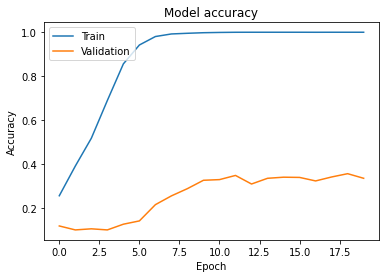

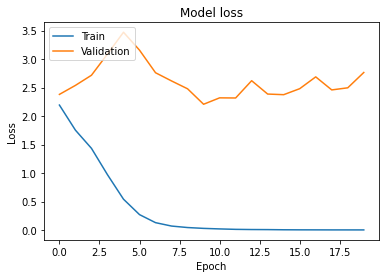

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: s15un658 with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: False
wandb: 	dropout: 0.1
wandb: 	fc_layer: 256
wandb: 	num_filters: [256, 128, 64, 32, 16]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 256


aug_False_bs_256_bn_True_drop_0.1_fc_256_fil_[256, 128, 64, 32, 16]_shape_[[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
506298
Epoch 1/20


In [ ]:
sweep_config = {
  "name": "Sweep 2 CS6910 Assignment 2 - Part A",
  "metric": {
      "name":"val_accuracy",
      "goal": "maximize"
  },
  "method": "random",
  "parameters": {
        "data_aug": {
            "values": [True, False]
        },
        "train_batch_size": {
            "values": [128, 256]
        },
        "batch_norm_use": {
            "values": [True, False]
        },
        "dropout": {
            "values": [0, 0.2, 0.1]
        },
        "num_filters": {
            "values": [[16, 32, 64, 128, 256], [32, 64, 128, 256, 512], [32, 32, 32, 32, 32],
                       [256, 128, 64, 32, 16]]
        },
        "fc_layer": {
            "values": [128, 256, 512]
        },
        "shape_of_filters_conv": {
            "values": [[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3)],
                       [(7, 7), (5, 5), (3, 3), (3, 3), (3, 3)],
                       [(3, 3), (3, 3), (3, 3), (5, 5), (7, 7)]]
        }
    }
}
#hyqwrmx5
sweep_id = wandb.sweep(sweep_config, entity="ee17b154tony", project="dl_assignment_2")
wandb.agent(sweep_id, train_validate_model_wandb, count=100)

Create sweep with ID: nhipwb3g
Sweep URL: https://wandb.ai/ee17b154tony/dl_assignment_2/sweeps/nhipwb3g


wandb: Agent Starting Run: h4puzbrt with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: True
wandb: 	dropout: 0
wandb: 	fc_layer: 256
wandb: 	num_filters: [256, 128, 64, 32, 16]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
wandb: 	train_batch_size: 128
wandb: Currently logged in as: ee17b154tony (use `wandb login --relogin` to force relogin)


aug_True_bs_128_bn_True_drop_0_fc_256_fil_[256, 128, 64, 32, 16]_shape_[[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
473530
Epoch 1/20


Run h4puzbrt errored: ResourceExhaustedError()
wandb: ERROR Run h4puzbrt errored: ResourceExhaustedError()
wandb: Agent Starting Run: w0wfmbop with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: True
wandb: 	dropout: 0.2
wandb: 	fc_layer: 256
wandb: 	num_filters: [32, 64, 128, 256, 512]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_True_drop_0.2_fc_256_fil_[32, 64, 128, 256, 512]_shape_[[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
7866826
Epoch 1/20
70/70 - 235s - loss: 2.2467 - accuracy: 0.2255 - val_loss: 2.4482 - val_accuracy: 0.1000
Epoch 2/20
70/70 - 227s - loss: 2.0179 - accuracy: 0.2843 - val_loss: 2.6213 - val_accuracy: 0.1060
Epoch 3/20
70/70 - 231s - loss: 1.9758 - accuracy: 0.2996 - val_loss: 2.5788 - val_accuracy: 0.1100
Epoch 4/20
70/70 - 229s - loss: 1.9306 - accuracy: 0.3215 - val_loss: 2.5466 - val_accuracy: 0.0990
Epoch 5/20
70/70 - 228s - loss: 1.8788 - accuracy: 0.3336 - val_loss: 2.3922 - val_accuracy: 0.1410
Epoch 6/20
70/70 - 226s - loss: 1.8691 - accuracy: 0.3428 - val_loss: 2.0888 - val_accuracy: 0.2510
Epoch 7/20
70/70 - 223s - loss: 1.8307 - accuracy: 0.3623 - val_loss: 1.9455 - val_accuracy: 0.3260
Epoch 8/20
70/70 - 209s - loss: 1.7930 - accurac

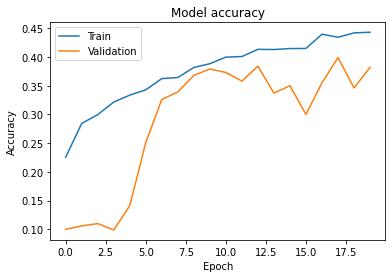

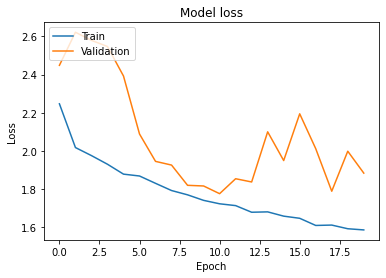

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: u0qvemyc with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: False
wandb: 	dropout: 0
wandb: 	fc_layer: 128
wandb: 	num_filters: [32, 32, 32, 32, 32]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
wandb: 	train_batch_size: 256


aug_False_bs_256_bn_True_drop_0_fc_128_fil_[32, 32, 32, 32, 32]_shape_[[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
113674
Epoch 1/20
35/35 - 126s - loss: 2.3130 - accuracy: 0.1552 - val_loss: 2.3054 - val_accuracy: 0.1100
Epoch 2/20
35/35 - 123s - loss: 2.1320 - accuracy: 0.2394 - val_loss: 2.3214 - val_accuracy: 0.1140
Epoch 3/20
35/35 - 123s - loss: 2.0416 - accuracy: 0.2813 - val_loss: 2.3416 - val_accuracy: 0.0970
Epoch 4/20
35/35 - 121s - loss: 1.9628 - accuracy: 0.3179 - val_loss: 2.3636 - val_accuracy: 0.1000
Epoch 5/20
35/35 - 119s - loss: 1.8978 - accuracy: 0.3396 - val_loss: 2.3877 - val_accuracy: 0.1160
Epoch 6/20
35/35 - 118s - loss: 1.8478 - accuracy: 0.3629 - val_loss: 2.4057 - val_accuracy: 0.1040
Epoch 7/20
35/35 - 121s - loss: 1.7932 - accuracy: 0.3857 - val_loss: 2.4202 - val_accuracy: 0.1180
Epoch 8/20
35/35 - 121s - loss: 1.7388 - accuracy: 0.

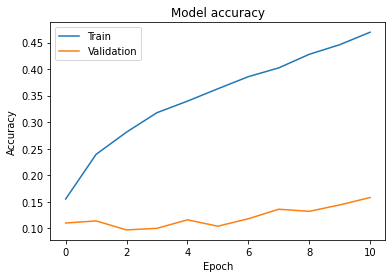

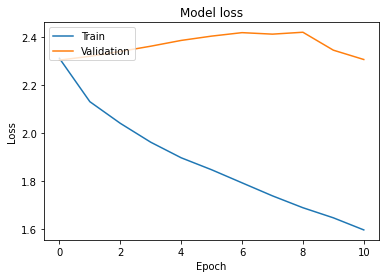

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: rji0svme with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0.2
wandb: 	fc_layer: 128
wandb: 	num_filters: [256, 128, 64, 32, 16]
wandb: 	shape_of_filters_conv: [[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_False_drop_0.2_fc_128_fil_[256, 128, 64, 32, 16]_shape_[[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
988282
Epoch 1/20


Run rji0svme errored: ResourceExhaustedError()
wandb: ERROR Run rji0svme errored: ResourceExhaustedError()
wandb: Agent Starting Run: 9jn3ls0z with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: False
wandb: 	dropout: 0.1
wandb: 	fc_layer: 256
wandb: 	num_filters: [32, 32, 32, 32, 32]
wandb: 	shape_of_filters_conv: [[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_False_bs_128_bn_False_drop_0.1_fc_256_fil_[32, 32, 32, 32, 32]_shape_[[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
192010
Epoch 1/20
70/70 - 127s - loss: 2.2954 - accuracy: 0.1284 - val_loss: 2.2746 - val_accuracy: 0.1460
Epoch 2/20
70/70 - 122s - loss: 2.2226 - accuracy: 0.1854 - val_loss: 2.1978 - val_accuracy: 0.1940
Epoch 3/20
70/70 - 122s - loss: 2.1543 - accuracy: 0.2202 - val_loss: 2.1489 - val_accuracy: 0.2170
Epoch 4/20
70/70 - 122s - loss: 2.1052 - accuracy: 0.2464 - val_loss: 2.1143 - val_accuracy: 0.2410
Epoch 5/20
70/70 - 123s - loss: 2.0759 - accuracy: 0.2553 - val_loss: 2.0968 - val_accuracy: 0.2520
Epoch 6/20
70/70 - 122s - loss: 2.0414 - accuracy: 0.2762 - val_loss: 2.0832 - val_accuracy: 0.2620
Epoch 7/20
70/70 - 124s - loss: 2.0254 - accuracy: 0.2825 - val_loss: 2.0365 - val_accuracy: 0.2760
Epoch 8/20
70/70 - 123s - loss: 1.9994 - accuracy:

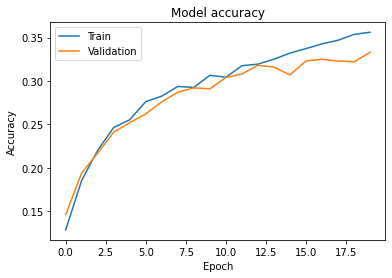

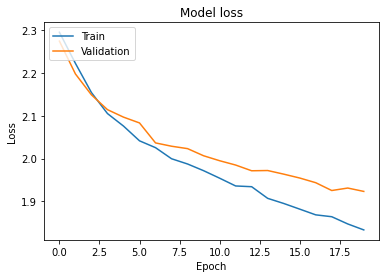

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 8jutc8x1 with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: True
wandb: 	dropout: 0.1
wandb: 	fc_layer: 512
wandb: 	num_filters: [32, 64, 128, 256, 512]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_True_drop_0.1_fc_512_fil_[32, 64, 128, 256, 512]_shape_[[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
8393930
Epoch 1/20
70/70 - 214s - loss: 2.2087 - accuracy: 0.2379 - val_loss: 2.4429 - val_accuracy: 0.1000
Epoch 2/20
70/70 - 212s - loss: 2.0058 - accuracy: 0.2878 - val_loss: 2.6934 - val_accuracy: 0.1000
Epoch 3/20
70/70 - 219s - loss: 1.9378 - accuracy: 0.3102 - val_loss: 2.7047 - val_accuracy: 0.1450
Epoch 4/20
70/70 - 220s - loss: 1.8811 - accuracy: 0.3367 - val_loss: 2.6164 - val_accuracy: 0.1240
Epoch 5/20
70/70 - 222s - loss: 1.8421 - accuracy: 0.3498 - val_loss: 2.3511 - val_accuracy: 0.1450
Epoch 6/20
70/70 - 220s - loss: 1.8270 - accuracy: 0.3492 - val_loss: 2.3974 - val_accuracy: 0.2080
Epoch 7/20
70/70 - 224s - loss: 1.7804 - accuracy: 0.3720 - val_loss: 1.9304 - val_accuracy: 0.3170
Epoch 8/20
70/70 - 222s - loss: 1.7498 - accurac

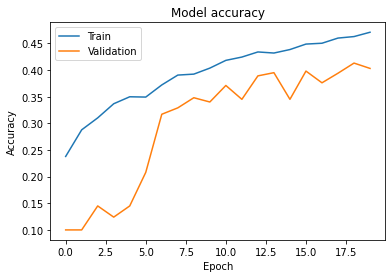

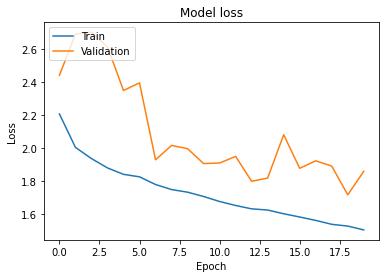

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: q9niwezv with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: True
wandb: 	dropout: 0.2
wandb: 	fc_layer: 128
wandb: 	num_filters: [256, 128, 64, 32, 16]
wandb: 	shape_of_filters_conv: [[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_True_drop_0.2_fc_128_fil_[256, 128, 64, 32, 16]_shape_[[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
990266
Epoch 1/20


Run q9niwezv errored: ResourceExhaustedError()
wandb: ERROR Run q9niwezv errored: ResourceExhaustedError()
wandb: Agent Starting Run: pb7c82zz with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: True
wandb: 	dropout: 0
wandb: 	fc_layer: 256
wandb: 	num_filters: [256, 128, 64, 32, 16]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
wandb: 	train_batch_size: 256


aug_True_bs_256_bn_True_drop_0_fc_256_fil_[256, 128, 64, 32, 16]_shape_[[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
473530
Epoch 1/20


Run pb7c82zz errored: ResourceExhaustedError()
wandb: ERROR Run pb7c82zz errored: ResourceExhaustedError()
wandb: Agent Starting Run: 9zjompiw with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: False
wandb: 	dropout: 0.2
wandb: 	fc_layer: 128
wandb: 	num_filters: [32, 32, 32, 32, 32]
wandb: 	shape_of_filters_conv: [[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 256


aug_False_bs_256_bn_False_drop_0.2_fc_128_fil_[32, 32, 32, 32, 32]_shape_[[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
125066
Epoch 1/20
35/35 - 129s - loss: 2.3020 - accuracy: 0.1121 - val_loss: 2.2987 - val_accuracy: 0.1260
Epoch 2/20
35/35 - 124s - loss: 2.2904 - accuracy: 0.1437 - val_loss: 2.2809 - val_accuracy: 0.1240
Epoch 3/20
35/35 - 124s - loss: 2.2490 - accuracy: 0.1725 - val_loss: 2.2205 - val_accuracy: 0.1880
Epoch 4/20
35/35 - 125s - loss: 2.1863 - accuracy: 0.2065 - val_loss: 2.1629 - val_accuracy: 0.2340
Epoch 5/20
35/35 - 125s - loss: 2.1398 - accuracy: 0.2298 - val_loss: 2.1307 - val_accuracy: 0.2270
Epoch 6/20
35/35 - 126s - loss: 2.1088 - accuracy: 0.2370 - val_loss: 2.1120 - val_accuracy: 0.2410
Epoch 7/20
35/35 - 125s - loss: 2.0856 - accuracy: 0.2485 - val_loss: 2.0933 - val_accuracy: 0.2480
Epoch 8/20
35/35 - 126s - loss: 2.0658 - accuracy:

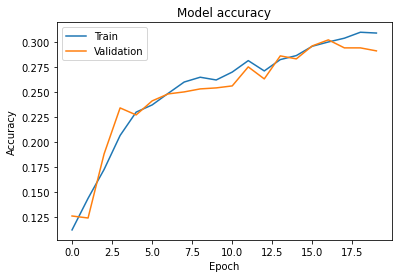

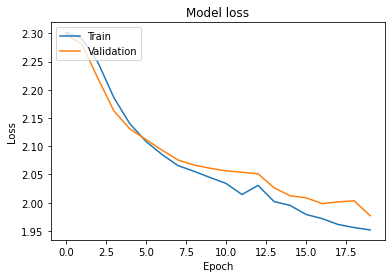

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: mr3jozh9 with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: True
wandb: 	dropout: 0
wandb: 	fc_layer: 256
wandb: 	num_filters: [256, 128, 64, 32, 16]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_True_drop_0_fc_256_fil_[256, 128, 64, 32, 16]_shape_[[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
506298
Epoch 1/20


Run mr3jozh9 errored: ResourceExhaustedError()
wandb: ERROR Run mr3jozh9 errored: ResourceExhaustedError()
wandb: Agent Starting Run: m43oklq4 with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0.1
wandb: 	fc_layer: 128
wandb: 	num_filters: [32, 64, 128, 256, 512]
wandb: 	shape_of_filters_conv: [[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 256


aug_True_bs_256_bn_False_drop_0.1_fc_128_fil_[32, 64, 128, 256, 512]_shape_[[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
2655178
Epoch 1/20
35/35 - 223s - loss: 2.2786 - accuracy: 0.1463 - val_loss: 2.2280 - val_accuracy: 0.1810
Epoch 2/20
35/35 - 223s - loss: 2.2022 - accuracy: 0.1882 - val_loss: 2.1769 - val_accuracy: 0.1870
Epoch 3/20
35/35 - 221s - loss: 2.1495 - accuracy: 0.2161 - val_loss: 2.1249 - val_accuracy: 0.2140
Epoch 4/20
35/35 - 219s - loss: 2.1185 - accuracy: 0.2361 - val_loss: 2.1270 - val_accuracy: 0.2240
Epoch 5/20
35/35 - 217s - loss: 2.0949 - accuracy: 0.2506 - val_loss: 2.0509 - val_accuracy: 0.2730
Epoch 6/20
35/35 - 216s - loss: 2.0845 - accuracy: 0.2525 - val_loss: 2.0513 - val_accuracy: 0.2630
Epoch 7/20
35/35 - 219s - loss: 2.0690 - accuracy: 0.2570 - val_loss: 2.0750 - val_accuracy: 0.2550
Epoch 8/20
35/35 - 218s - loss: 2.0525 - accura

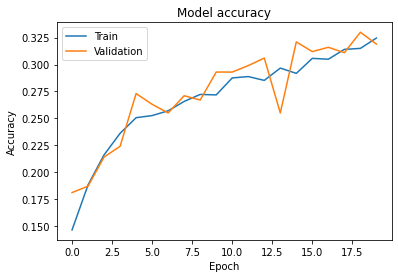

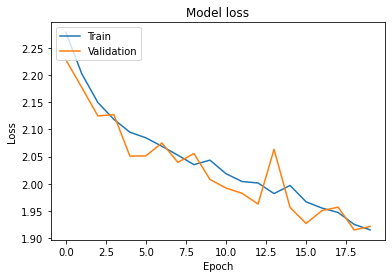

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: lripuamr with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0.1
wandb: 	fc_layer: 256
wandb: 	num_filters: [256, 128, 64, 32, 16]
wandb: 	shape_of_filters_conv: [[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 256


aug_True_bs_256_bn_False_drop_0.1_fc_256_fil_[256, 128, 64, 32, 16]_shape_[[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
1022458
Epoch 1/20


Run lripuamr errored: ResourceExhaustedError()
wandb: ERROR Run lripuamr errored: ResourceExhaustedError()
wandb: Agent Starting Run: j3pn9b7r with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: False
wandb: 	dropout: 0.2
wandb: 	fc_layer: 256
wandb: 	num_filters: [32, 32, 32, 32, 32]
wandb: 	shape_of_filters_conv: [[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 256


aug_False_bs_256_bn_True_drop_0.2_fc_256_fil_[32, 32, 32, 32, 32]_shape_[[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
192650
Epoch 1/20


In [ ]:
sweep_config = {
  "name": "Sweep 2 CS6910 Assignment 2 - Part A",
  "metric": {
      "name":"val_accuracy",
      "goal": "maximize"
  },
  "method": "random",
  "parameters": {
        "data_aug": {
            "values": [True, False]
        },
        "train_batch_size": {
            "values": [128, 256]
        },
        "batch_norm_use": {
            "values": [True, False]
        },
        "dropout": {
            "values": [0, 0.2, 0.1]
        },
        "num_filters": {
            "values": [[16, 32, 64, 128, 256], [32, 64, 128, 256, 512], [32, 32, 32, 32, 32],
                       [256, 128, 64, 32, 16]]
        },
        "fc_layer": {
            "values": [128, 256, 512]
        },
        "shape_of_filters_conv": {
            "values": [[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3)],
                       [(7, 7), (5, 5), (3, 3), (3, 3), (3, 3)],
                       [(3, 3), (3, 3), (3, 3), (5, 5), (7, 7)]]
        }
    }
}
#hyqwrmx5
sweep_id = wandb.sweep(sweep_config, entity="ee17b154tony", project="dl_assignment_2")
wandb.agent(sweep_id, train_validate_model_wandb, count=100)

Create sweep with ID: sic7tqun
Sweep URL: https://wandb.ai/ee17b154tony/dl_assignment_2/sweeps/sic7tqun


wandb: Agent Starting Run: bptlcm30 with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: False
wandb: 	dropout: 0.1
wandb: 	fc_layer: 128
wandb: 	num_filters: [32, 64, 128, 256, 512]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 256
wandb: Currently logged in as: ee17b154tony (use `wandb login --relogin` to force relogin)


aug_False_bs_256_bn_False_drop_0.1_fc_128_fil_[32, 64, 128, 256, 512]_shape_[[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
3208394
Epoch 1/20
35/35 - 140s - loss: 2.2918 - accuracy: 0.1358 - val_loss: 2.2686 - val_accuracy: 0.1460
Epoch 2/20
35/35 - 121s - loss: 2.2118 - accuracy: 0.1910 - val_loss: 2.1813 - val_accuracy: 0.2100
Epoch 3/20
35/35 - 114s - loss: 2.1291 - accuracy: 0.2406 - val_loss: 2.0890 - val_accuracy: 0.2480
Epoch 4/20
35/35 - 117s - loss: 2.0397 - accuracy: 0.2790 - val_loss: 2.0967 - val_accuracy: 0.2540
Epoch 5/20
35/35 - 114s - loss: 2.0048 - accuracy: 0.3022 - val_loss: 2.0173 - val_accuracy: 0.2730
Epoch 6/20
35/35 - 114s - loss: 1.9660 - accuracy: 0.3088 - val_loss: 2.0010 - val_accuracy: 0.2890
Epoch 7/20
35/35 - 115s - loss: 1.9428 - accuracy: 0.3147 - val_loss: 1.9851 - val_accuracy: 0.2930
Epoch 8/20
35/35 - 114s - loss: 1.9196 - accur

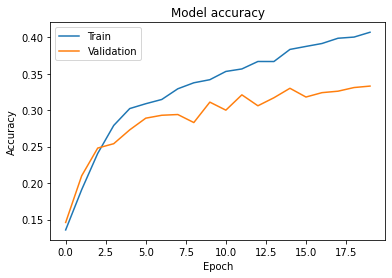

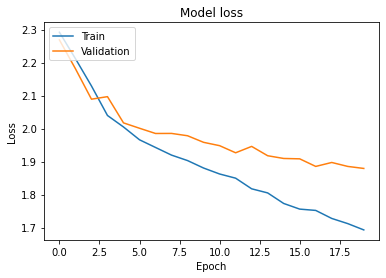

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: o2or4oys with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: True
wandb: 	dropout: 0
wandb: 	fc_layer: 256
wandb: 	num_filters: [256, 128, 64, 32, 16]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_True_drop_0_fc_256_fil_[256, 128, 64, 32, 16]_shape_[[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
506298
Epoch 1/20


Run o2or4oys errored: ResourceExhaustedError()
wandb: ERROR Run o2or4oys errored: ResourceExhaustedError()
wandb: Agent Starting Run: rwwfl1cw with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: False
wandb: 	dropout: 0.1
wandb: 	fc_layer: 256
wandb: 	num_filters: [32, 64, 128, 256, 512]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_False_bs_128_bn_False_drop_0.1_fc_256_fil_[32, 64, 128, 256, 512]_shape_[[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
4848202
Epoch 1/20
70/70 - 119s - loss: 2.2354 - accuracy: 0.1710 - val_loss: 2.1376 - val_accuracy: 0.2190
Epoch 2/20
70/70 - 115s - loss: 2.0839 - accuracy: 0.2518 - val_loss: 2.0410 - val_accuracy: 0.2620
Epoch 3/20
70/70 - 114s - loss: 1.9999 - accuracy: 0.2941 - val_loss: 2.0229 - val_accuracy: 0.2900
Epoch 4/20
70/70 - 114s - loss: 1.9448 - accuracy: 0.3142 - val_loss: 1.9675 - val_accuracy: 0.2980
Epoch 5/20
70/70 - 116s - loss: 1.9124 - accuracy: 0.3281 - val_loss: 1.9704 - val_accuracy: 0.2960
Epoch 6/20
70/70 - 115s - loss: 1.8739 - accuracy: 0.3464 - val_loss: 1.9763 - val_accuracy: 0.2990
Epoch 7/20
70/70 - 115s - loss: 1.8403 - accuracy: 0.3508 - val_loss: 1.9646 - val_accuracy: 0.3010
Epoch 8/20
70/70 - 114s - loss: 1.8012 - accur

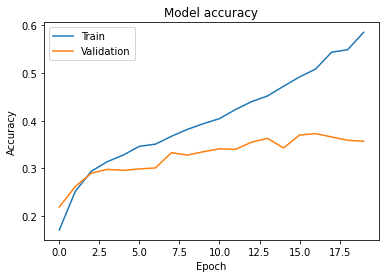

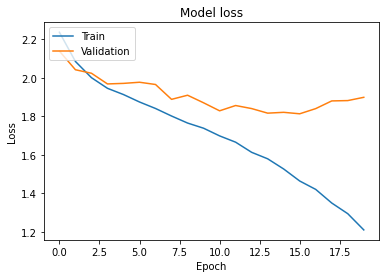

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: f0barnqc with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: False
wandb: 	dropout: 0.1
wandb: 	fc_layer: 512
wandb: 	num_filters: [32, 64, 128, 256, 512]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_False_bs_128_bn_False_drop_0.1_fc_512_fil_[32, 64, 128, 256, 512]_shape_[[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
8127818
Epoch 1/20
70/70 - 116s - loss: 2.2496 - accuracy: 0.1605 - val_loss: 2.1503 - val_accuracy: 0.2090
Epoch 2/20
70/70 - 113s - loss: 2.0689 - accuracy: 0.2612 - val_loss: 2.0414 - val_accuracy: 0.2770
Epoch 3/20
70/70 - 113s - loss: 1.9882 - accuracy: 0.2996 - val_loss: 2.0121 - val_accuracy: 0.2830
Epoch 4/20
70/70 - 114s - loss: 1.9334 - accuracy: 0.3217 - val_loss: 2.0045 - val_accuracy: 0.2830
Epoch 5/20
70/70 - 114s - loss: 1.8992 - accuracy: 0.3357 - val_loss: 1.9811 - val_accuracy: 0.2840
Epoch 6/20
70/70 - 114s - loss: 1.8483 - accuracy: 0.3522 - val_loss: 1.9561 - val_accuracy: 0.3030
Epoch 7/20
70/70 - 114s - loss: 1.7995 - accuracy: 0.3731 - val_loss: 1.9264 - val_accuracy: 0.3190
Epoch 8/20
70/70 - 114s - loss: 1.7584 - accur

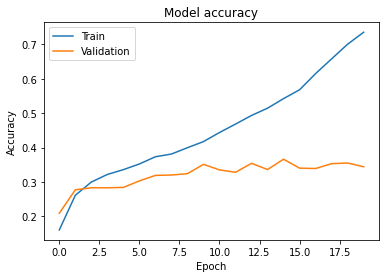

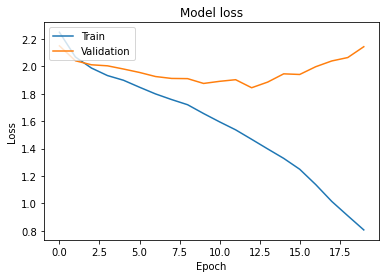

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: s143urq0 with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0.2
wandb: 	fc_layer: 256
wandb: 	num_filters: [16, 32, 64, 128, 256]
wandb: 	shape_of_filters_conv: [[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_False_drop_0.2_fc_256_fil_[16, 32, 64, 128, 256]_shape_[[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
1454122
Epoch 1/20
70/70 - 202s - loss: 2.2813 - accuracy: 0.1310 - val_loss: 2.2437 - val_accuracy: 0.1670
Epoch 2/20
70/70 - 198s - loss: 2.1764 - accuracy: 0.1993 - val_loss: 2.1253 - val_accuracy: 0.2250
Epoch 3/20
70/70 - 198s - loss: 2.1377 - accuracy: 0.2213 - val_loss: 2.1174 - val_accuracy: 0.2330
Epoch 4/20
70/70 - 200s - loss: 2.1055 - accuracy: 0.2350 - val_loss: 2.1175 - val_accuracy: 0.2290
Epoch 5/20
70/70 - 199s - loss: 2.0832 - accuracy: 0.2505 - val_loss: 2.0579 - val_accuracy: 0.2560
Epoch 6/20
70/70 - 200s - loss: 2.0626 - accuracy: 0.2614 - val_loss: 2.0851 - val_accuracy: 0.2480
Epoch 7/20
70/70 - 199s - loss: 2.0453 - accuracy: 0.2687 - val_loss: 2.0415 - val_accuracy: 0.2630
Epoch 8/20
70/70 - 199s - loss: 2.0242 - accurac

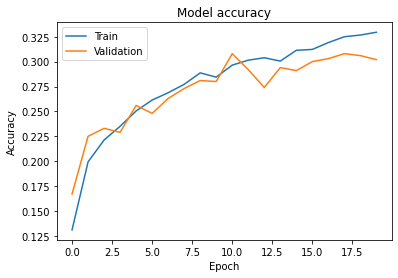

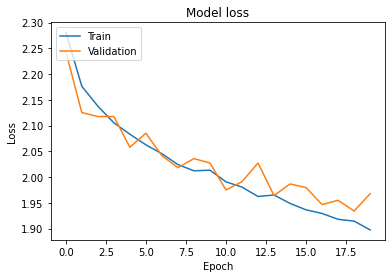

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: fy6p7r5w with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: False
wandb: 	dropout: 0.1
wandb: 	fc_layer: 256
wandb: 	num_filters: [256, 128, 64, 32, 16]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 256


aug_False_bs_256_bn_True_drop_0.1_fc_256_fil_[256, 128, 64, 32, 16]_shape_[[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
506298
Epoch 1/20


Run fy6p7r5w errored: ResourceExhaustedError()
wandb: ERROR Run fy6p7r5w errored: ResourceExhaustedError()
wandb: Agent Starting Run: 8a2jvsyl with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: False
wandb: 	dropout: 0.1
wandb: 	fc_layer: 128
wandb: 	num_filters: [256, 128, 64, 32, 16]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 256


aug_False_bs_256_bn_False_drop_0.1_fc_128_fil_[256, 128, 64, 32, 16]_shape_[[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
451706
Epoch 1/20


Run 8a2jvsyl errored: ResourceExhaustedError()
wandb: ERROR Run 8a2jvsyl errored: ResourceExhaustedError()
wandb: Agent Starting Run: ll8so113 with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0.2
wandb: 	fc_layer: 512
wandb: 	num_filters: [32, 32, 32, 32, 32]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 256


aug_True_bs_256_bn_False_drop_0.2_fc_512_fil_[32, 32, 32, 32, 32]_shape_[[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
453130
Epoch 1/20
35/35 - 202s - loss: 2.2998 - accuracy: 0.1151 - val_loss: 2.2923 - val_accuracy: 0.1330
Epoch 2/20
35/35 - 198s - loss: 2.2798 - accuracy: 0.1467 - val_loss: 2.2549 - val_accuracy: 0.1590
Epoch 3/20
35/35 - 197s - loss: 2.2272 - accuracy: 0.1801 - val_loss: 2.2080 - val_accuracy: 0.2040
Epoch 4/20
35/35 - 198s - loss: 2.1720 - accuracy: 0.2173 - val_loss: 2.2074 - val_accuracy: 0.1960
Epoch 5/20
35/35 - 198s - loss: 2.1324 - accuracy: 0.2268 - val_loss: 2.1443 - val_accuracy: 0.2250
Epoch 6/20
35/35 - 199s - loss: 2.1053 - accuracy: 0.2434 - val_loss: 2.1455 - val_accuracy: 0.2310
Epoch 7/20
35/35 - 199s - loss: 2.0883 - accuracy: 0.2482 - val_loss: 2.1387 - val_accuracy: 0.2380
Epoch 8/20
35/35 - 198s - loss: 2.0796 - accuracy: 

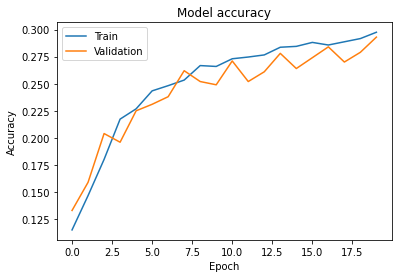

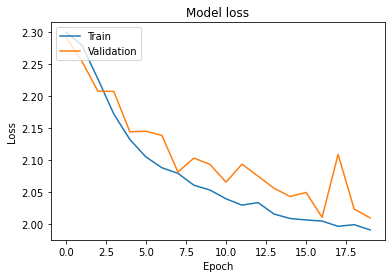

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: uv08tl08 with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: False
wandb: 	dropout: 0.2
wandb: 	fc_layer: 256
wandb: 	num_filters: [256, 128, 64, 32, 16]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_False_bs_128_bn_True_drop_0.2_fc_256_fil_[256, 128, 64, 32, 16]_shape_[[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
506298
Epoch 1/20


Run uv08tl08 errored: ResourceExhaustedError()
wandb: ERROR Run uv08tl08 errored: ResourceExhaustedError()
wandb: Agent Starting Run: g2u5p4qj with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0.1
wandb: 	fc_layer: 256
wandb: 	num_filters: [16, 32, 64, 128, 256]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
wandb: 	train_batch_size: 256


aug_True_bs_256_bn_False_drop_0.1_fc_256_fil_[16, 32, 64, 128, 256]_shape_[[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
2099370
Epoch 1/20
35/35 - 203s - loss: 2.2751 - accuracy: 0.1450 - val_loss: 2.2296 - val_accuracy: 0.1940
Epoch 2/20
35/35 - 199s - loss: 2.2024 - accuracy: 0.1926 - val_loss: 2.1709 - val_accuracy: 0.2060
Epoch 3/20
35/35 - 200s - loss: 2.1637 - accuracy: 0.2006 - val_loss: 2.1587 - val_accuracy: 0.2110
Epoch 4/20
35/35 - 200s - loss: 2.1392 - accuracy: 0.2139 - val_loss: 2.1350 - val_accuracy: 0.2230
Epoch 5/20
35/35 - 200s - loss: 2.1148 - accuracy: 0.2314 - val_loss: 2.1103 - val_accuracy: 0.2370
Epoch 6/20
35/35 - 202s - loss: 2.0950 - accuracy: 0.2479 - val_loss: 2.1074 - val_accuracy: 0.2190
Epoch 7/20
35/35 - 201s - loss: 2.0820 - accuracy: 0.2473 - val_loss: 2.0807 - val_accuracy: 0.2460
Epoch 8/20
35/35 - 201s - loss: 2.0509 - accurac

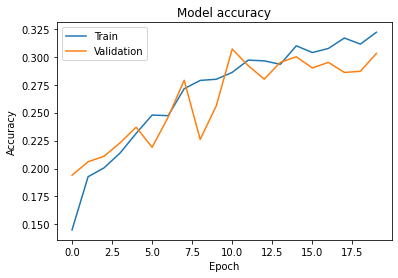

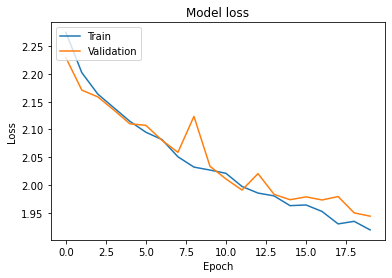

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: jpuxx5q6 with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: False
wandb: 	dropout: 0.1
wandb: 	fc_layer: 256
wandb: 	num_filters: [32, 32, 32, 32, 32]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_False_bs_128_bn_False_drop_0.1_fc_256_fil_[32, 32, 32, 32, 32]_shape_[[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
245514
Epoch 1/20
70/70 - 117s - loss: 2.2924 - accuracy: 0.1294 - val_loss: 2.2685 - val_accuracy: 0.1400
Epoch 2/20
70/70 - 114s - loss: 2.2319 - accuracy: 0.1720 - val_loss: 2.2093 - val_accuracy: 0.1830
Epoch 3/20
70/70 - 113s - loss: 2.1660 - accuracy: 0.2208 - val_loss: 2.1383 - val_accuracy: 0.2180
Epoch 4/20
70/70 - 113s - loss: 2.0904 - accuracy: 0.2546 - val_loss: 2.0822 - val_accuracy: 0.2450
Epoch 5/20
70/70 - 114s - loss: 2.0426 - accuracy: 0.2760 - val_loss: 2.0578 - val_accuracy: 0.2550
Epoch 6/20
70/70 - 114s - loss: 2.0087 - accuracy: 0.2900 - val_loss: 2.0280 - val_accuracy: 0.2760
Epoch 7/20
70/70 - 114s - loss: 1.9870 - accuracy: 0.3038 - val_loss: 2.0214 - val_accuracy: 0.2740
Epoch 8/20
70/70 - 114s - loss: 1.9623 - accuracy:

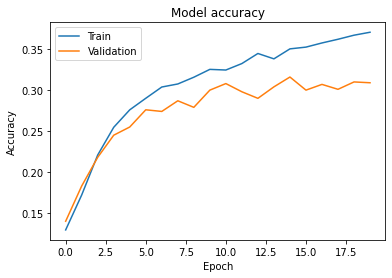

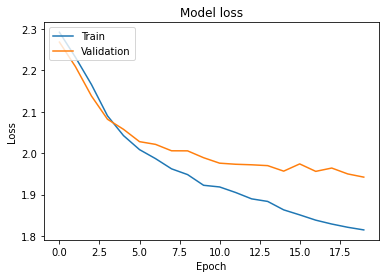

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: otavyxnu with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: False
wandb: 	dropout: 0.1
wandb: 	fc_layer: 128
wandb: 	num_filters: [32, 64, 128, 256, 512]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
wandb: 	train_batch_size: 256


aug_False_bs_256_bn_False_drop_0.1_fc_128_fil_[32, 64, 128, 256, 512]_shape_[[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
7599306
Epoch 1/20
35/35 - 118s - loss: 2.2846 - accuracy: 0.1368 - val_loss: 2.2373 - val_accuracy: 0.1740
Epoch 2/20
35/35 - 114s - loss: 2.1813 - accuracy: 0.2043 - val_loss: 2.1561 - val_accuracy: 0.2120
Epoch 3/20
35/35 - 114s - loss: 2.0897 - accuracy: 0.2506 - val_loss: 2.0618 - val_accuracy: 0.2730
Epoch 4/20
35/35 - 114s - loss: 2.0216 - accuracy: 0.2853 - val_loss: 2.0323 - val_accuracy: 0.2750
Epoch 5/20
35/35 - 114s - loss: 1.9878 - accuracy: 0.3005 - val_loss: 2.0152 - val_accuracy: 0.2710
Epoch 6/20
35/35 - 114s - loss: 1.9509 - accuracy: 0.3134 - val_loss: 2.0092 - val_accuracy: 0.2810
Epoch 7/20
35/35 - 114s - loss: 1.9206 - accuracy: 0.3251 - val_loss: 2.0112 - val_accuracy: 0.2890
Epoch 8/20
35/35 - 115s - loss: 1.9182 - accur

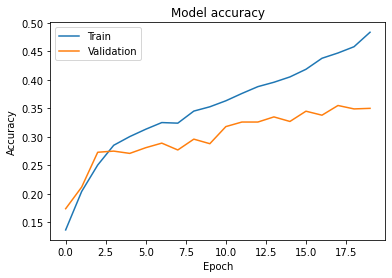

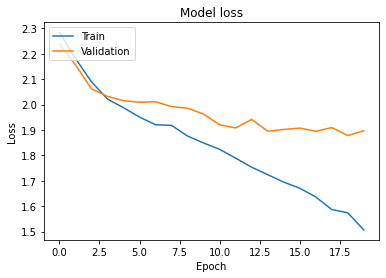

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 9kn92jb0 with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: False
wandb: 	dropout: 0.1
wandb: 	fc_layer: 512
wandb: 	num_filters: [16, 32, 64, 128, 256]
wandb: 	shape_of_filters_conv: [[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_False_bs_128_bn_False_drop_0.1_fc_512_fil_[16, 32, 64, 128, 256]_shape_[[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
2505514
Epoch 1/20
70/70 - 117s - loss: 2.2709 - accuracy: 0.1517 - val_loss: 2.1998 - val_accuracy: 0.1800
Epoch 2/20
70/70 - 114s - loss: 2.1381 - accuracy: 0.2215 - val_loss: 2.0871 - val_accuracy: 0.2400
Epoch 3/20
70/70 - 116s - loss: 2.0508 - accuracy: 0.2677 - val_loss: 2.0359 - val_accuracy: 0.2750
Epoch 4/20
70/70 - 116s - loss: 1.9944 - accuracy: 0.2952 - val_loss: 2.0230 - val_accuracy: 0.2750
Epoch 5/20
70/70 - 116s - loss: 1.9694 - accuracy: 0.3050 - val_loss: 1.9989 - val_accuracy: 0.2770
Epoch 6/20
70/70 - 115s - loss: 1.9308 - accuracy: 0.3169 - val_loss: 1.9735 - val_accuracy: 0.2970
Epoch 7/20
70/70 - 116s - loss: 1.8946 - accuracy: 0.3305 - val_loss: 1.9945 - val_accuracy: 0.2930
Epoch 8/20
70/70 - 117s - loss: 1.8754 - accura

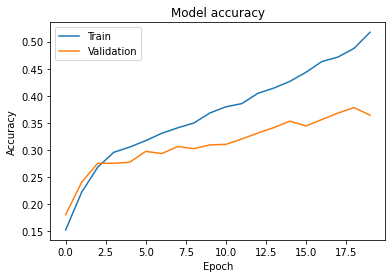

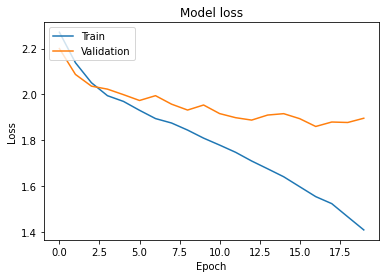

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: a8unxtcf with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: False
wandb: 	dropout: 0.1
wandb: 	fc_layer: 256
wandb: 	num_filters: [16, 32, 64, 128, 256]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
wandb: 	train_batch_size: 256


aug_False_bs_256_bn_False_drop_0.1_fc_256_fil_[16, 32, 64, 128, 256]_shape_[[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
2099370
Epoch 1/20
35/35 - 115s - loss: 2.2868 - accuracy: 0.1493 - val_loss: 2.2451 - val_accuracy: 0.1830
Epoch 2/20
35/35 - 114s - loss: 2.1768 - accuracy: 0.2075 - val_loss: 2.1319 - val_accuracy: 0.2040
Epoch 3/20
35/35 - 114s - loss: 2.1016 - accuracy: 0.2431 - val_loss: 2.0872 - val_accuracy: 0.2260
Epoch 4/20
35/35 - 114s - loss: 2.0485 - accuracy: 0.2699 - val_loss: 2.0555 - val_accuracy: 0.2520
Epoch 5/20
35/35 - 115s - loss: 2.0217 - accuracy: 0.2802 - val_loss: 2.0547 - val_accuracy: 0.2720
Epoch 6/20
35/35 - 115s - loss: 1.9848 - accuracy: 0.2992 - val_loss: 2.0215 - val_accuracy: 0.2800
Epoch 7/20
35/35 - 116s - loss: 1.9783 - accuracy: 0.3032 - val_loss: 2.0034 - val_accuracy: 0.2890
Epoch 8/20
35/35 - 116s - loss: 1.9403 - accura

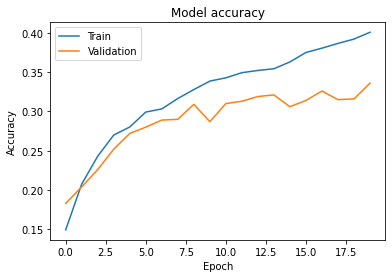

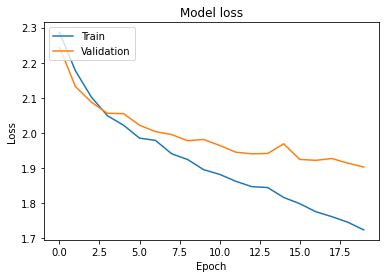

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: en93nvu8 with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: False
wandb: 	dropout: 0
wandb: 	fc_layer: 256
wandb: 	num_filters: [32, 64, 128, 256, 512]
wandb: 	shape_of_filters_conv: [[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_False_bs_128_bn_True_drop_0_fc_256_fil_[32, 64, 128, 256, 512]_shape_[[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
3709130
Epoch 1/20
70/70 - 124s - loss: 2.1588 - accuracy: 0.2569 - val_loss: 2.3871 - val_accuracy: 0.1000
Epoch 2/20
70/70 - 117s - loss: 1.8143 - accuracy: 0.3639 - val_loss: 2.5602 - val_accuracy: 0.1000
Epoch 3/20
70/70 - 118s - loss: 1.6020 - accuracy: 0.4558 - val_loss: 2.6980 - val_accuracy: 0.1020
Epoch 4/20
70/70 - 118s - loss: 1.3702 - accuracy: 0.5526 - val_loss: 2.5887 - val_accuracy: 0.1280
Epoch 5/20
70/70 - 118s - loss: 1.1122 - accuracy: 0.6590 - val_loss: 2.4876 - val_accuracy: 0.1940
Epoch 6/20
70/70 - 118s - loss: 0.8621 - accuracy: 0.7717 - val_loss: 2.3211 - val_accuracy: 0.2290
Epoch 7/20
70/70 - 118s - loss: 0.6198 - accuracy: 0.8706 - val_loss: 2.1914 - val_accuracy: 0.2480
Epoch 8/20
70/70 - 118s - loss: 0.4236 - accuracy

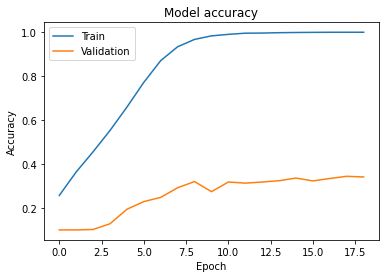

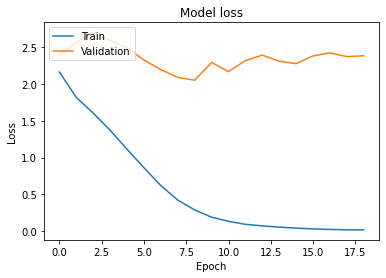

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: ovrk9sez with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: True
wandb: 	dropout: 0.2
wandb: 	fc_layer: 256
wandb: 	num_filters: [256, 128, 64, 32, 16]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 256


aug_True_bs_256_bn_True_drop_0.2_fc_256_fil_[256, 128, 64, 32, 16]_shape_[[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
506298
Epoch 1/20


Run ovrk9sez errored: ResourceExhaustedError()
wandb: ERROR Run ovrk9sez errored: ResourceExhaustedError()
wandb: Agent Starting Run: autykwuf with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: True
wandb: 	dropout: 0
wandb: 	fc_layer: 512
wandb: 	num_filters: [16, 32, 64, 128, 256]
wandb: 	shape_of_filters_conv: [[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 256


aug_True_bs_256_bn_True_drop_0_fc_512_fil_[16, 32, 64, 128, 256]_shape_[[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
2507498
Epoch 1/20
35/35 - 204s - loss: 2.3451 - accuracy: 0.1980 - val_loss: 2.3165 - val_accuracy: 0.1040
Epoch 2/20
35/35 - 200s - loss: 2.0986 - accuracy: 0.2544 - val_loss: 2.3870 - val_accuracy: 0.1000
Epoch 3/20
35/35 - 205s - loss: 2.0480 - accuracy: 0.2676 - val_loss: 2.4264 - val_accuracy: 0.1070
Epoch 4/20
35/35 - 202s - loss: 1.9940 - accuracy: 0.2942 - val_loss: 2.4890 - val_accuracy: 0.1030
Epoch 5/20
35/35 - 200s - loss: 1.9774 - accuracy: 0.3064 - val_loss: 2.5314 - val_accuracy: 0.1080
Epoch 6/20
35/35 - 200s - loss: 1.9457 - accuracy: 0.3126 - val_loss: 2.5149 - val_accuracy: 0.1150
Epoch 7/20
35/35 - 199s - loss: 1.9277 - accuracy: 0.3224 - val_loss: 2.4725 - val_accuracy: 0.1220
Epoch 8/20
35/35 - 200s - loss: 1.9165 - accuracy: 

In [ ]:
sweep_config = {
  "name": "Sweep 2 CS6910 Assignment 2 - Part A",
  "metric": {
      "name":"val_accuracy",
      "goal": "maximize"
  },
  "method": "random",
  "parameters": {
        "data_aug": {
            "values": [True, False]
        },
        "train_batch_size": {
            "values": [128, 256]
        },
        "batch_norm_use": {
            "values": [True, False]
        },
        "dropout": {
            "values": [0, 0.2, 0.1]
        },
        "num_filters": {
            "values": [[16, 32, 64, 128, 256], [32, 64, 128, 256, 512], [32, 32, 32, 32, 32],
                       [256, 128, 64, 32, 16]]
        },
        "fc_layer": {
            "values": [128, 256, 512]
        },
        "shape_of_filters_conv": {
            "values": [[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3)],
                       [(7, 7), (5, 5), (3, 3), (3, 3), (3, 3)],
                       [(3, 3), (3, 3), (3, 3), (5, 5), (7, 7)]]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, entity="ee17b154tony", project="dl_assignment_2")
wandb.agent(sweep_id, train_validate_model_wandb, count=100)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: o91i7o1p
Sweep URL: https://wandb.ai/ee17b154tony/dl_assignment_2/sweeps/o91i7o1p


wandb: Agent Starting Run: rm4ue423 with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: True
wandb: 	dropout: 0
wandb: 	fc_layer: 256
wandb: 	num_filters: [32, 64, 128, 256, 512]
wandb: 	shape_of_filters_conv: [[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 256
wandb: Currently logged in as: ee17b154tony (use `wandb login --relogin` to force relogin)


aug_True_bs_256_bn_True_drop_0_fc_256_fil_[32, 64, 128, 256, 512]_shape_[[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
3709130
Epoch 1/10
35/35 - 252s - loss: 2.2885 - accuracy: 0.2085 - val_loss: 2.3167 - val_accuracy: 0.1040
Epoch 2/10
35/35 - 211s - loss: 2.0500 - accuracy: 0.2714 - val_loss: 2.3912 - val_accuracy: 0.1210
Epoch 3/10
35/35 - 206s - loss: 1.9953 - accuracy: 0.2879 - val_loss: 2.4713 - val_accuracy: 0.1040
Epoch 4/10
35/35 - 207s - loss: 1.9620 - accuracy: 0.3017 - val_loss: 2.4511 - val_accuracy: 0.1120
Epoch 5/10
35/35 - 205s - loss: 1.9188 - accuracy: 0.3141 - val_loss: 2.5220 - val_accuracy: 0.1040
Epoch 6/10
35/35 - 208s - loss: 1.8952 - accuracy: 0.3301 - val_loss: 2.5664 - val_accuracy: 0.1030


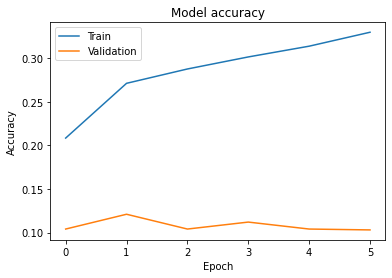

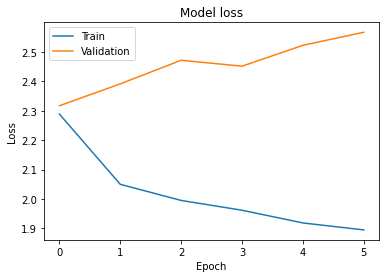

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: vi143quz with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: False
wandb: 	dropout: 0
wandb: 	fc_layer: 256
wandb: 	num_filters: [32, 64, 128, 256, 512]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 256


aug_False_bs_256_bn_True_drop_0_fc_256_fil_[32, 64, 128, 256, 512]_shape_[[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
4852170
Epoch 1/10
35/35 - 126s - loss: 2.2928 - accuracy: 0.2328 - val_loss: 2.3196 - val_accuracy: 0.1000
Epoch 2/10
35/35 - 120s - loss: 1.8588 - accuracy: 0.3491 - val_loss: 2.3664 - val_accuracy: 0.1000
Epoch 3/10
35/35 - 119s - loss: 1.6897 - accuracy: 0.4156 - val_loss: 2.4448 - val_accuracy: 0.1030
Epoch 4/10
35/35 - 120s - loss: 1.5150 - accuracy: 0.4860 - val_loss: 2.4800 - val_accuracy: 0.1090
Epoch 5/10
35/35 - 116s - loss: 1.3132 - accuracy: 0.5755 - val_loss: 2.6065 - val_accuracy: 0.1250
Epoch 6/10
35/35 - 116s - loss: 1.1010 - accuracy: 0.6751 - val_loss: 2.6380 - val_accuracy: 0.1190


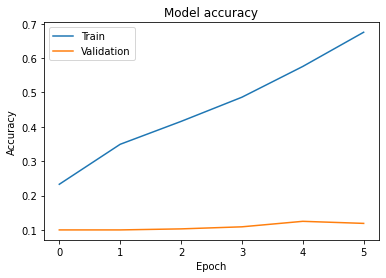

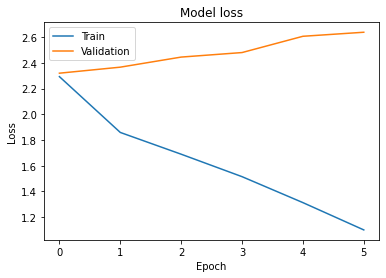

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: i9as875t with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: False
wandb: 	dropout: 0.2
wandb: 	fc_layer: 256
wandb: 	num_filters: [32, 64, 128, 256, 512]
wandb: 	shape_of_filters_conv: [[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 256


aug_False_bs_256_bn_False_drop_0.2_fc_256_fil_[32, 64, 128, 256, 512]_shape_[[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
3705162
Epoch 1/10
35/35 - 121s - loss: 2.2876 - accuracy: 0.1346 - val_loss: 2.2438 - val_accuracy: 0.1610
Epoch 2/10
35/35 - 114s - loss: 2.1912 - accuracy: 0.2028 - val_loss: 2.1549 - val_accuracy: 0.2150
Epoch 3/10
35/35 - 114s - loss: 2.1047 - accuracy: 0.2368 - val_loss: 2.0768 - val_accuracy: 0.2440
Epoch 4/10
35/35 - 114s - loss: 2.0503 - accuracy: 0.2697 - val_loss: 2.0349 - val_accuracy: 0.2740
Epoch 5/10
35/35 - 113s - loss: 2.0058 - accuracy: 0.2878 - val_loss: 2.0016 - val_accuracy: 0.2880
Epoch 6/10
35/35 - 114s - loss: 1.9690 - accuracy: 0.3098 - val_loss: 1.9891 - val_accuracy: 0.2780
Epoch 7/10
35/35 - 114s - loss: 1.9439 - accuracy: 0.3164 - val_loss: 2.0002 - val_accuracy: 0.2950
Epoch 8/10
35/35 - 114s - loss: 1.9178 - accur

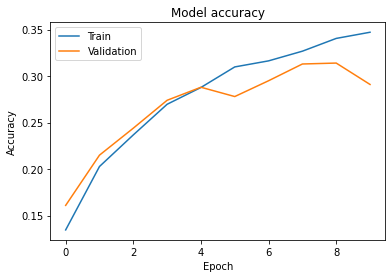

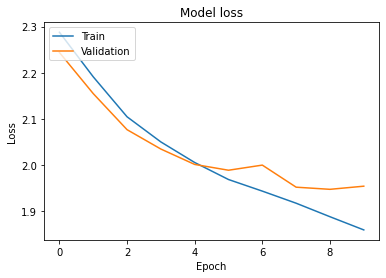

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 07a2tub6 with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0
wandb: 	fc_layer: 512
wandb: 	num_filters: [16, 32, 64, 128, 256]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 256


aug_True_bs_256_bn_False_drop_0_fc_512_fil_[16, 32, 64, 128, 256]_shape_[[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
3675050
Epoch 1/10
35/35 - 201s - loss: 2.2776 - accuracy: 0.1408 - val_loss: 2.2356 - val_accuracy: 0.1650
Epoch 2/10
35/35 - 197s - loss: 2.2083 - accuracy: 0.1936 - val_loss: 2.1924 - val_accuracy: 0.1990
Epoch 3/10
35/35 - 201s - loss: 2.1436 - accuracy: 0.2292 - val_loss: 2.1182 - val_accuracy: 0.2290
Epoch 4/10
35/35 - 201s - loss: 2.1090 - accuracy: 0.2342 - val_loss: 2.0981 - val_accuracy: 0.2510
Epoch 5/10
35/35 - 201s - loss: 2.0745 - accuracy: 0.2565 - val_loss: 2.0674 - val_accuracy: 0.2620
Epoch 6/10
35/35 - 198s - loss: 2.0378 - accuracy: 0.2696 - val_loss: 2.0364 - val_accuracy: 0.2880
Epoch 7/10
35/35 - 199s - loss: 2.0177 - accuracy: 0.2846 - val_loss: 1.9947 - val_accuracy: 0.3000
Epoch 8/10
35/35 - 198s - loss: 2.0027 - accuracy:

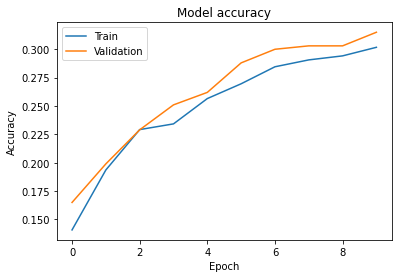

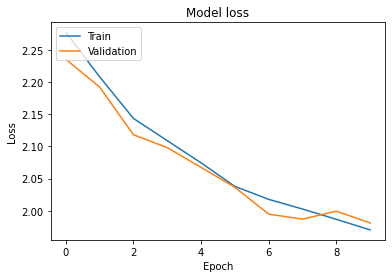

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 9y3ukgma with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: False
wandb: 	dropout: 0.2
wandb: 	fc_layer: 128
wandb: 	num_filters: [256, 128, 64, 32, 16]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
wandb: 	train_batch_size: 128


aug_False_bs_128_bn_True_drop_0.2_fc_128_fil_[256, 128, 64, 32, 16]_shape_[[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
463930
Epoch 1/10


Run 9y3ukgma errored: ResourceExhaustedError()
wandb: ERROR Run 9y3ukgma errored: ResourceExhaustedError()
wandb: Agent Starting Run: aqqw1hj5 with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: False
wandb: 	dropout: 0.1
wandb: 	fc_layer: 256
wandb: 	num_filters: [32, 32, 32, 32, 32]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
wandb: 	train_batch_size: 256


aug_False_bs_256_bn_True_drop_0.1_fc_256_fil_[32, 32, 32, 32, 32]_shape_[[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
131466
Epoch 1/10
35/35 - 117s - loss: 2.3262 - accuracy: 0.1607 - val_loss: 2.3017 - val_accuracy: 0.1200
Epoch 2/10
35/35 - 115s - loss: 2.1321 - accuracy: 0.2328 - val_loss: 2.3072 - val_accuracy: 0.1090
Epoch 3/10
35/35 - 116s - loss: 2.0664 - accuracy: 0.2656 - val_loss: 2.3166 - val_accuracy: 0.1000
Epoch 4/10
35/35 - 116s - loss: 1.9960 - accuracy: 0.2938 - val_loss: 2.3302 - val_accuracy: 0.1000
Epoch 5/10
35/35 - 117s - loss: 1.9417 - accuracy: 0.3169 - val_loss: 2.3476 - val_accuracy: 0.0990
Epoch 6/10
35/35 - 117s - loss: 1.8956 - accuracy: 0.3307 - val_loss: 2.3543 - val_accuracy: 0.1200


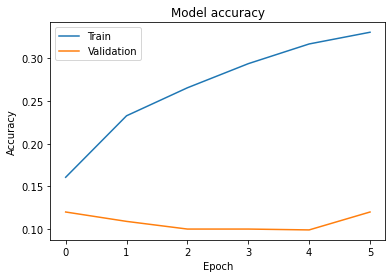

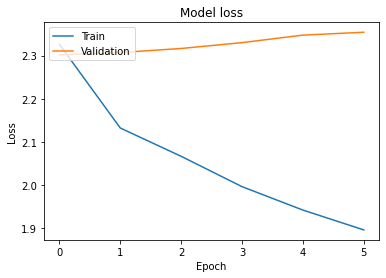

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zk4bu5kj with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: False
wandb: 	dropout: 0
wandb: 	fc_layer: 512
wandb: 	num_filters: [256, 128, 64, 32, 16]
wandb: 	shape_of_filters_conv: [[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 256


aug_False_bs_256_bn_False_drop_0_fc_512_fil_[256, 128, 64, 32, 16]_shape_[[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
1090810
Epoch 1/10


Run zk4bu5kj errored: ResourceExhaustedError()
wandb: ERROR Run zk4bu5kj errored: ResourceExhaustedError()
wandb: Agent Starting Run: 7gkxanbi with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0.2
wandb: 	fc_layer: 128
wandb: 	num_filters: [16, 32, 64, 128, 256]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_False_drop_0.2_fc_128_fil_[16, 32, 64, 128, 256]_shape_[[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
1213226
Epoch 1/10
70/70 - 200s - loss: 2.2781 - accuracy: 0.1418 - val_loss: 2.2257 - val_accuracy: 0.1770
Epoch 2/10
70/70 - 198s - loss: 2.2035 - accuracy: 0.1850 - val_loss: 2.1666 - val_accuracy: 0.2050
Epoch 3/10
70/70 - 199s - loss: 2.1553 - accuracy: 0.2178 - val_loss: 2.1102 - val_accuracy: 0.2330
Epoch 4/10
70/70 - 201s - loss: 2.1209 - accuracy: 0.2310 - val_loss: 2.0976 - val_accuracy: 0.2240
Epoch 5/10
70/70 - 203s - loss: 2.0874 - accuracy: 0.2473 - val_loss: 2.0461 - val_accuracy: 0.2600
Epoch 6/10
70/70 - 202s - loss: 2.0618 - accuracy: 0.2654 - val_loss: 2.0398 - val_accuracy: 0.2700
Epoch 7/10
70/70 - 199s - loss: 2.0439 - accuracy: 0.2735 - val_loss: 2.0000 - val_accuracy: 0.2760
Epoch 8/10
70/70 - 200s - loss: 2.0384 - accurac

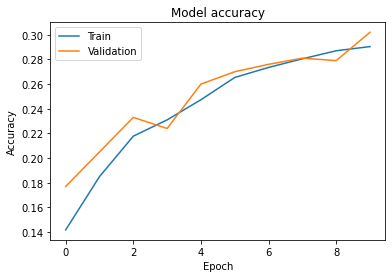

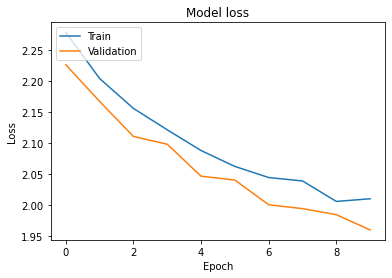

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: rboylfr0 with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: False
wandb: 	dropout: 0.2
wandb: 	fc_layer: 128
wandb: 	num_filters: [32, 64, 128, 256, 512]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
wandb: 	train_batch_size: 256


aug_False_bs_256_bn_False_drop_0.2_fc_128_fil_[32, 64, 128, 256, 512]_shape_[[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
7599306
Epoch 1/10
35/35 - 122s - loss: 2.2884 - accuracy: 0.1241 - val_loss: 2.2417 - val_accuracy: 0.1620
Epoch 2/10
35/35 - 116s - loss: 2.2023 - accuracy: 0.2029 - val_loss: 2.1498 - val_accuracy: 0.2280
Epoch 3/10
35/35 - 115s - loss: 2.1062 - accuracy: 0.2476 - val_loss: 2.0536 - val_accuracy: 0.2690
Epoch 4/10
35/35 - 115s - loss: 2.0500 - accuracy: 0.2746 - val_loss: 2.0290 - val_accuracy: 0.2860
Epoch 5/10
35/35 - 119s - loss: 2.0200 - accuracy: 0.2843 - val_loss: 2.0115 - val_accuracy: 0.2880
Epoch 6/10
35/35 - 116s - loss: 1.9934 - accuracy: 0.2964 - val_loss: 1.9868 - val_accuracy: 0.2830
Epoch 7/10
35/35 - 115s - loss: 1.9605 - accuracy: 0.3052 - val_loss: 1.9646 - val_accuracy: 0.3020
Epoch 8/10
35/35 - 117s - loss: 1.9579 - accur

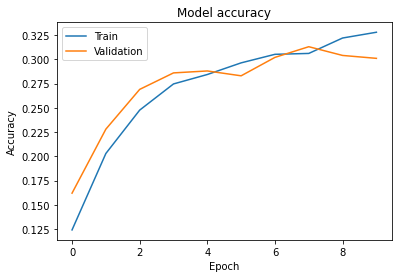

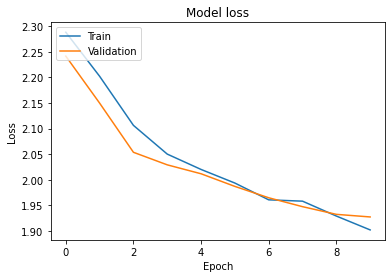

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: b2jhsar5 with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: False
wandb: 	dropout: 0
wandb: 	fc_layer: 128
wandb: 	num_filters: [32, 64, 128, 256, 512]
wandb: 	shape_of_filters_conv: [[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 256


aug_False_bs_256_bn_False_drop_0_fc_128_fil_[32, 64, 128, 256, 512]_shape_[[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
2655178
Epoch 1/10
35/35 - 121s - loss: 2.2784 - accuracy: 0.1445 - val_loss: 2.2054 - val_accuracy: 0.2100
Epoch 2/10
35/35 - 117s - loss: 2.1520 - accuracy: 0.2190 - val_loss: 2.1160 - val_accuracy: 0.2310
Epoch 3/10
35/35 - 117s - loss: 2.0751 - accuracy: 0.2591 - val_loss: 2.0811 - val_accuracy: 0.2580
Epoch 4/10
35/35 - 117s - loss: 2.0309 - accuracy: 0.2766 - val_loss: 2.0482 - val_accuracy: 0.2520
Epoch 5/10
35/35 - 117s - loss: 1.9928 - accuracy: 0.2964 - val_loss: 2.0078 - val_accuracy: 0.2870
Epoch 6/10
35/35 - 117s - loss: 1.9703 - accuracy: 0.3045 - val_loss: 2.0059 - val_accuracy: 0.2830
Epoch 7/10
35/35 - 117s - loss: 1.9497 - accuracy: 0.3104 - val_loss: 1.9826 - val_accuracy: 0.2890
Epoch 8/10
35/35 - 116s - loss: 1.9257 - accurac

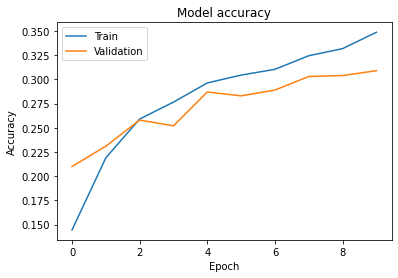

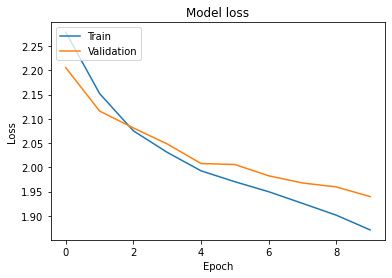

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: xqc4r5jc with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0.2
wandb: 	fc_layer: 256
wandb: 	num_filters: [32, 32, 32, 32, 32]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
wandb: 	train_batch_size: 256


aug_True_bs_256_bn_False_drop_0.2_fc_256_fil_[32, 32, 32, 32, 32]_shape_[[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
130826
Epoch 1/10
35/35 - 202s - loss: 2.3013 - accuracy: 0.1231 - val_loss: 2.2980 - val_accuracy: 0.1220
Epoch 2/10
35/35 - 196s - loss: 2.2936 - accuracy: 0.1529 - val_loss: 2.2800 - val_accuracy: 0.1690
Epoch 3/10
35/35 - 197s - loss: 2.2585 - accuracy: 0.1782 - val_loss: 2.2118 - val_accuracy: 0.1840
Epoch 4/10
35/35 - 198s - loss: 2.1955 - accuracy: 0.1894 - val_loss: 2.1731 - val_accuracy: 0.1780
Epoch 5/10
35/35 - 195s - loss: 2.1657 - accuracy: 0.1995 - val_loss: 2.1612 - val_accuracy: 0.1860
Epoch 6/10
35/35 - 196s - loss: 2.1573 - accuracy: 0.2053 - val_loss: 2.1526 - val_accuracy: 0.1930
Epoch 7/10
35/35 - 197s - loss: 2.1574 - accuracy: 0.2070 - val_loss: 2.1461 - val_accuracy: 0.1820
Epoch 8/10
35/35 - 194s - loss: 2.1488 - accuracy: 

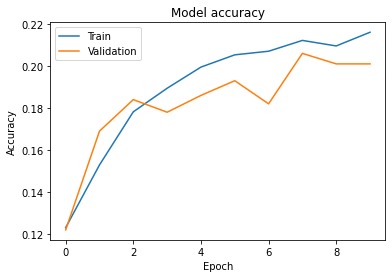

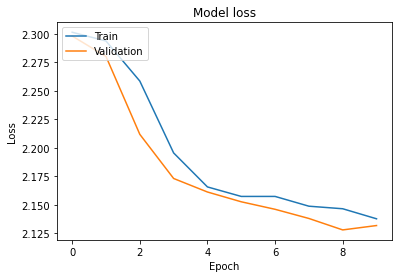

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: lk6bv712 with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0
wandb: 	fc_layer: 256
wandb: 	num_filters: [16, 32, 64, 128, 256]
wandb: 	shape_of_filters_conv: [[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 256


aug_True_bs_256_bn_False_drop_0_fc_256_fil_[16, 32, 64, 128, 256]_shape_[[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
1454122
Epoch 1/10
35/35 - 201s - loss: 2.2957 - accuracy: 0.1257 - val_loss: 2.2698 - val_accuracy: 0.1750
Epoch 2/10
35/35 - 197s - loss: 2.2336 - accuracy: 0.1819 - val_loss: 2.1876 - val_accuracy: 0.2010
Epoch 3/10
35/35 - 199s - loss: 2.1589 - accuracy: 0.2115 - val_loss: 2.1157 - val_accuracy: 0.2270
Epoch 4/10
35/35 - 195s - loss: 2.1067 - accuracy: 0.2370 - val_loss: 2.0787 - val_accuracy: 0.2300
Epoch 5/10
35/35 - 195s - loss: 2.0854 - accuracy: 0.2559 - val_loss: 2.0817 - val_accuracy: 0.2570
Epoch 6/10
35/35 - 198s - loss: 2.0745 - accuracy: 0.2539 - val_loss: 2.0476 - val_accuracy: 0.2510
Epoch 7/10
35/35 - 201s - loss: 2.0553 - accuracy: 0.2648 - val_loss: 2.0336 - val_accuracy: 0.2830
Epoch 8/10
35/35 - 198s - loss: 2.0417 - accuracy:

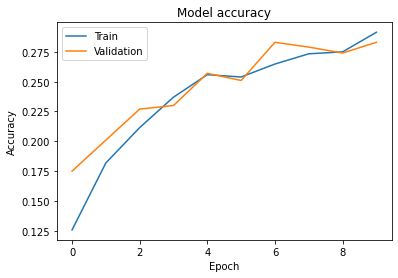

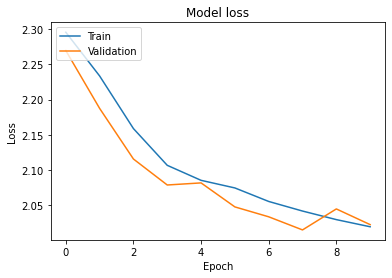

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: iy09i2d6 with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0.2
wandb: 	fc_layer: 512
wandb: 	num_filters: [16, 32, 64, 128, 256]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
wandb: 	train_batch_size: 256


aug_True_bs_256_bn_False_drop_0.2_fc_512_fil_[16, 32, 64, 128, 256]_shape_[[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
2364330
Epoch 1/10
35/35 - 197s - loss: 2.2958 - accuracy: 0.1246 - val_loss: 2.2707 - val_accuracy: 0.1690
Epoch 2/10
35/35 - 194s - loss: 2.2312 - accuracy: 0.1845 - val_loss: 2.1655 - val_accuracy: 0.1880
Epoch 3/10
35/35 - 196s - loss: 2.1682 - accuracy: 0.2060 - val_loss: 2.1313 - val_accuracy: 0.2090
Epoch 4/10
35/35 - 195s - loss: 2.1289 - accuracy: 0.2205 - val_loss: 2.1149 - val_accuracy: 0.2230
Epoch 5/10
35/35 - 195s - loss: 2.1162 - accuracy: 0.2310 - val_loss: 2.1298 - val_accuracy: 0.2210
Epoch 6/10
35/35 - 195s - loss: 2.0910 - accuracy: 0.2392 - val_loss: 2.1097 - val_accuracy: 0.2150
Epoch 7/10
35/35 - 197s - loss: 2.0698 - accuracy: 0.2598 - val_loss: 2.0481 - val_accuracy: 0.2540
Epoch 8/10
35/35 - 195s - loss: 2.0538 - accurac

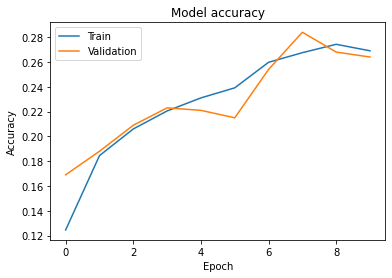

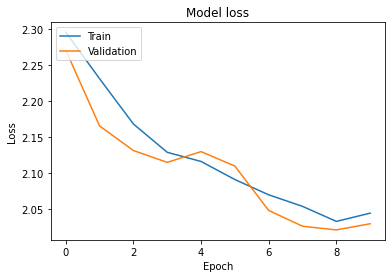

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 8z8oq6sv with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0
wandb: 	fc_layer: 512
wandb: 	num_filters: [256, 128, 64, 32, 16]
wandb: 	shape_of_filters_conv: [[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_False_drop_0_fc_512_fil_[256, 128, 64, 32, 16]_shape_[[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
1090810
Epoch 1/10


Run 8z8oq6sv errored: ResourceExhaustedError()
wandb: ERROR Run 8z8oq6sv errored: ResourceExhaustedError()
wandb: Agent Starting Run: 7l314ubo with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: False
wandb: 	dropout: 0.2
wandb: 	fc_layer: 128
wandb: 	num_filters: [16, 32, 64, 128, 256]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
wandb: 	train_batch_size: 256


aug_False_bs_256_bn_False_drop_0.2_fc_128_fil_[16, 32, 64, 128, 256]_shape_[[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
1966890
Epoch 1/10
35/35 - 114s - loss: 2.2907 - accuracy: 0.1273 - val_loss: 2.2585 - val_accuracy: 0.1760
Epoch 2/10
35/35 - 112s - loss: 2.2188 - accuracy: 0.1867 - val_loss: 2.1763 - val_accuracy: 0.1960
Epoch 3/10
35/35 - 112s - loss: 2.1438 - accuracy: 0.2265 - val_loss: 2.0931 - val_accuracy: 0.2260
Epoch 4/10
35/35 - 111s - loss: 2.0802 - accuracy: 0.2491 - val_loss: 2.0532 - val_accuracy: 0.2550
Epoch 5/10
35/35 - 112s - loss: 2.0531 - accuracy: 0.2687 - val_loss: 2.0429 - val_accuracy: 0.2660
Epoch 6/10
35/35 - 112s - loss: 2.0160 - accuracy: 0.2835 - val_loss: 2.0224 - val_accuracy: 0.2650
Epoch 7/10
35/35 - 110s - loss: 1.9965 - accuracy: 0.2881 - val_loss: 2.0086 - val_accuracy: 0.2830
Epoch 8/10
35/35 - 113s - loss: 1.9823 - accura

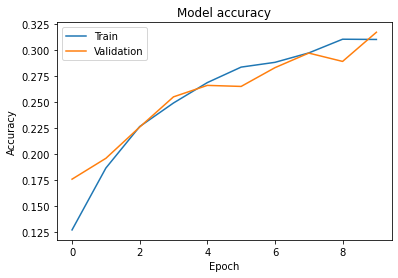

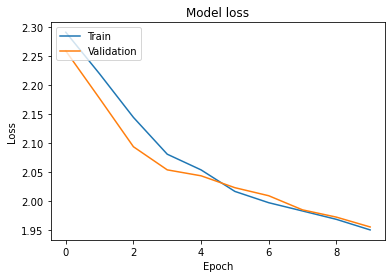

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: xcfd4e59 with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: True
wandb: 	dropout: 0
wandb: 	fc_layer: 256
wandb: 	num_filters: [32, 32, 32, 32, 32]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
wandb: 	train_batch_size: 256


aug_True_bs_256_bn_True_drop_0_fc_256_fil_[32, 32, 32, 32, 32]_shape_[[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
131466
Epoch 1/10
35/35 - 197s - loss: 2.4480 - accuracy: 0.1391 - val_loss: 2.3024 - val_accuracy: 0.1070
Epoch 2/10
35/35 - 196s - loss: 2.1992 - accuracy: 0.1979 - val_loss: 2.3094 - val_accuracy: 0.1190
Epoch 3/10
35/35 - 192s - loss: 2.1322 - accuracy: 0.2298 - val_loss: 2.3286 - val_accuracy: 0.1100
Epoch 4/10
35/35 - 196s - loss: 2.0928 - accuracy: 0.2463 - val_loss: 2.3446 - val_accuracy: 0.1020
Epoch 5/10
35/35 - 200s - loss: 2.0565 - accuracy: 0.2659 - val_loss: 2.3659 - val_accuracy: 0.1020
Epoch 6/10
35/35 - 198s - loss: 2.0317 - accuracy: 0.2712 - val_loss: 2.4164 - val_accuracy: 0.1000


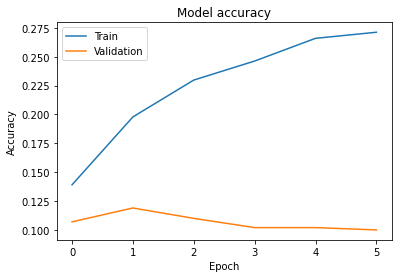

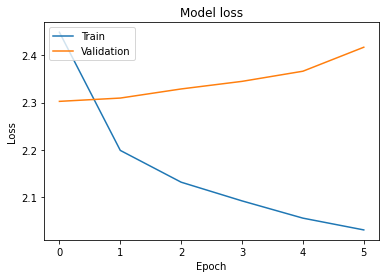

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 70m3ftiq with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0.2
wandb: 	fc_layer: 512
wandb: 	num_filters: [32, 64, 128, 256, 512]
wandb: 	shape_of_filters_conv: [[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 256


aug_True_bs_256_bn_False_drop_0.2_fc_512_fil_[32, 64, 128, 256, 512]_shape_[[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
5805130
Epoch 1/10
35/35 - 199s - loss: 2.2940 - accuracy: 0.1236 - val_loss: 2.2572 - val_accuracy: 0.1650
Epoch 2/10
35/35 - 196s - loss: 2.2466 - accuracy: 0.1664 - val_loss: 2.2088 - val_accuracy: 0.1840
Epoch 3/10
35/35 - 195s - loss: 2.1736 - accuracy: 0.2027 - val_loss: 2.1493 - val_accuracy: 0.2130
Epoch 4/10
35/35 - 196s - loss: 2.1148 - accuracy: 0.2334 - val_loss: 2.0921 - val_accuracy: 0.2430
Epoch 5/10
35/35 - 197s - loss: 2.0767 - accuracy: 0.2520 - val_loss: 2.0551 - val_accuracy: 0.2600
Epoch 6/10
35/35 - 198s - loss: 2.0478 - accuracy: 0.2647 - val_loss: 2.0411 - val_accuracy: 0.2750
Epoch 7/10
35/35 - 196s - loss: 2.0335 - accuracy: 0.2778 - val_loss: 2.0417 - val_accuracy: 0.2710
Epoch 8/10
35/35 - 199s - loss: 2.0195 - accura

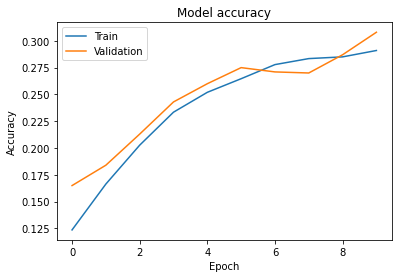

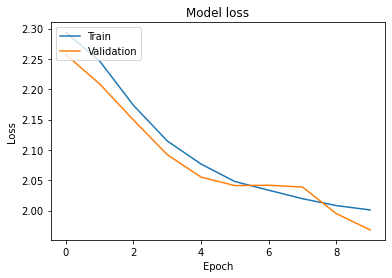

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: vlc5vbov with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: False
wandb: 	dropout: 0
wandb: 	fc_layer: 128
wandb: 	num_filters: [32, 64, 128, 256, 512]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
wandb: 	train_batch_size: 256


aug_False_bs_256_bn_False_drop_0_fc_128_fil_[32, 64, 128, 256, 512]_shape_[[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
7599306
Epoch 1/10
35/35 - 114s - loss: 2.2586 - accuracy: 0.1576 - val_loss: 2.1972 - val_accuracy: 0.1840
Epoch 2/10
35/35 - 113s - loss: 2.1573 - accuracy: 0.2177 - val_loss: 2.1461 - val_accuracy: 0.2190
Epoch 3/10
35/35 - 113s - loss: 2.0588 - accuracy: 0.2656 - val_loss: 2.0467 - val_accuracy: 0.2690
Epoch 4/10
35/35 - 114s - loss: 2.0004 - accuracy: 0.2942 - val_loss: 2.0398 - val_accuracy: 0.2890
Epoch 5/10
35/35 - 113s - loss: 1.9740 - accuracy: 0.3009 - val_loss: 2.0063 - val_accuracy: 0.2680
Epoch 6/10
35/35 - 113s - loss: 1.9315 - accuracy: 0.3206 - val_loss: 1.9743 - val_accuracy: 0.3010
Epoch 7/10
35/35 - 113s - loss: 1.8996 - accuracy: 0.3301 - val_loss: 1.9645 - val_accuracy: 0.3080
Epoch 8/10
35/35 - 113s - loss: 1.8970 - accurac

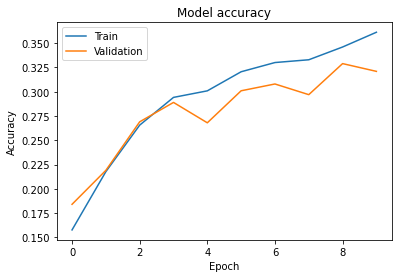

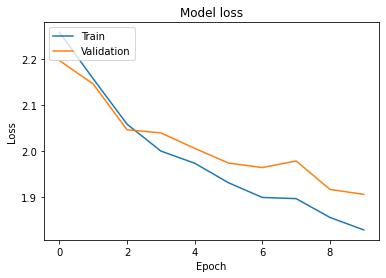

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 7kv14m73 with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: False
wandb: 	dropout: 0.2
wandb: 	fc_layer: 128
wandb: 	num_filters: [32, 64, 128, 256, 512]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 256


aug_False_bs_256_bn_True_drop_0.2_fc_128_fil_[32, 64, 128, 256, 512]_shape_[[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
3212362
Epoch 1/10
35/35 - 119s - loss: 2.2978 - accuracy: 0.1934 - val_loss: 2.3219 - val_accuracy: 0.1220
Epoch 2/10
35/35 - 116s - loss: 1.9953 - accuracy: 0.2858 - val_loss: 2.3481 - val_accuracy: 0.1160
Epoch 3/10
35/35 - 115s - loss: 1.8692 - accuracy: 0.3348 - val_loss: 2.3647 - val_accuracy: 0.1000
Epoch 4/10
35/35 - 115s - loss: 1.7426 - accuracy: 0.3899 - val_loss: 2.4495 - val_accuracy: 0.1070
Epoch 5/10
35/35 - 115s - loss: 1.6407 - accuracy: 0.4311 - val_loss: 2.4565 - val_accuracy: 0.1080
Epoch 6/10
35/35 - 115s - loss: 1.5127 - accuracy: 0.4810 - val_loss: 2.4752 - val_accuracy: 0.1000


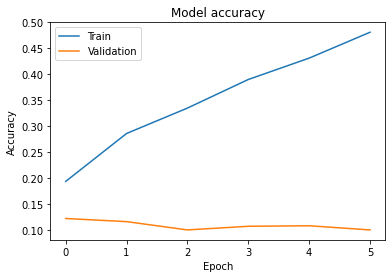

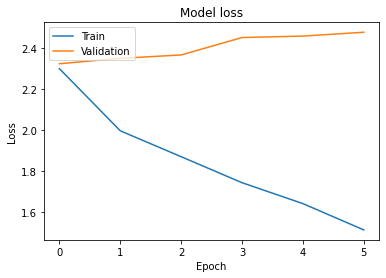

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 5k11mrba with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: False
wandb: 	dropout: 0.2
wandb: 	fc_layer: 256
wandb: 	num_filters: [32, 64, 128, 256, 512]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 256


aug_False_bs_256_bn_False_drop_0.2_fc_256_fil_[32, 64, 128, 256, 512]_shape_[[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
4848202
Epoch 1/10
35/35 - 115s - loss: 2.2754 - accuracy: 0.1445 - val_loss: 2.1920 - val_accuracy: 0.2070
Epoch 2/10
35/35 - 113s - loss: 2.1440 - accuracy: 0.2161 - val_loss: 2.1049 - val_accuracy: 0.2300
Epoch 3/10
35/35 - 112s - loss: 2.0760 - accuracy: 0.2594 - val_loss: 2.0423 - val_accuracy: 0.2590
Epoch 4/10
35/35 - 113s - loss: 2.0219 - accuracy: 0.2818 - val_loss: 2.0106 - val_accuracy: 0.2730
Epoch 5/10
35/35 - 113s - loss: 1.9961 - accuracy: 0.2997 - val_loss: 1.9990 - val_accuracy: 0.2780
Epoch 6/10
35/35 - 113s - loss: 1.9534 - accuracy: 0.3119 - val_loss: 1.9626 - val_accuracy: 0.3090
Epoch 7/10
35/35 - 113s - loss: 1.9362 - accuracy: 0.3209 - val_loss: 1.9488 - val_accuracy: 0.3000
Epoch 8/10
35/35 - 115s - loss: 1.9204 - accur

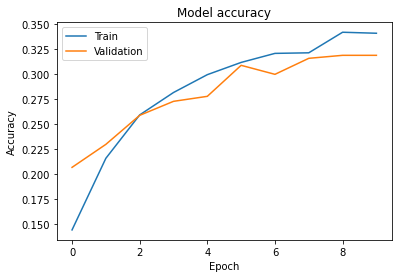

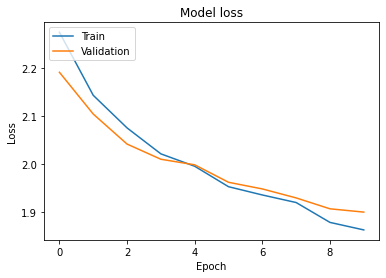

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 3wercxgw with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: False
wandb: 	dropout: 0.1
wandb: 	fc_layer: 512
wandb: 	num_filters: [256, 128, 64, 32, 16]
wandb: 	shape_of_filters_conv: [[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 256


aug_False_bs_256_bn_False_drop_0.1_fc_512_fil_[256, 128, 64, 32, 16]_shape_[[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
1090810
Epoch 1/10


Run 3wercxgw errored: ResourceExhaustedError()
wandb: ERROR Run 3wercxgw errored: ResourceExhaustedError()
wandb: Agent Starting Run: qekrukxp with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: False
wandb: 	dropout: 0.2
wandb: 	fc_layer: 256
wandb: 	num_filters: [256, 128, 64, 32, 16]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 256


aug_False_bs_256_bn_False_drop_0.2_fc_256_fil_[256, 128, 64, 32, 16]_shape_[[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
504314
Epoch 1/10


Run qekrukxp errored: ResourceExhaustedError()
wandb: ERROR Run qekrukxp errored: ResourceExhaustedError()
wandb: Agent Starting Run: sj2fv057 with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: False
wandb: 	dropout: 0.1
wandb: 	fc_layer: 128
wandb: 	num_filters: [32, 32, 32, 32, 32]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 256


aug_False_bs_256_bn_True_drop_0.1_fc_128_fil_[32, 32, 32, 32, 32]_shape_[[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
142346
Epoch 1/10
35/35 - 115s - loss: 2.4725 - accuracy: 0.1323 - val_loss: 2.3086 - val_accuracy: 0.1000
Epoch 2/10
35/35 - 113s - loss: 2.2180 - accuracy: 0.1972 - val_loss: 2.3314 - val_accuracy: 0.1000
Epoch 3/10
35/35 - 113s - loss: 2.1102 - accuracy: 0.2382 - val_loss: 2.3544 - val_accuracy: 0.1000
Epoch 4/10
35/35 - 113s - loss: 2.0561 - accuracy: 0.2700 - val_loss: 2.3864 - val_accuracy: 0.0990
Epoch 5/10
35/35 - 113s - loss: 2.0089 - accuracy: 0.2822 - val_loss: 2.3914 - val_accuracy: 0.0970
Epoch 6/10


In [ ]:
sweep_config = {
  "name": "Sweep 2 CS6910 Assignment 2 - Part A",
  "metric": {
      "name":"val_accuracy",
      "goal": "maximize"
  },
  "method": "random",
  "parameters": {
        "data_aug": {
            "values": [True, False]
        },
        "train_batch_size": {
            "values": [128, 256]
        },
        "batch_norm_use": {
            "values": [True, False]
        },
        "dropout": {
            "values": [0, 0.2, 0.1]
        },
        "num_filters": {
            "values": [[16, 32, 64, 128, 256], [32, 64, 128, 256, 512], [32, 32, 32, 32, 32],
                       [256, 128, 64, 32, 16]]
        },
        "fc_layer": {
            "values": [128, 256, 512]
        },
        "shape_of_filters_conv": {
            "values": [[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3)],
                       [(7, 7), (5, 5), (3, 3), (3, 3), (3, 3)],
                       [(3, 3), (3, 3), (3, 3), (5, 5), (7, 7)]]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, entity="ee17b154tony", project="dl_assignment_2")
wandb.agent(sweep_id, train_validate_model_wandb, count=25)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: 5hmhpp6i
Sweep URL: https://wandb.ai/ee17b154tony/dl_assignment_2/sweeps/5hmhpp6i


wandb: Agent Starting Run: swdsso67 with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: True
wandb: 	dropout: 0
wandb: 	fc_layer: 512
wandb: 	num_filters: [32, 64, 128, 256, 512]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
wandb: 	train_batch_size: 256
wandb: Currently logged in as: ee17b154tony (use `wandb login --relogin` to force relogin)


aug_True_bs_256_bn_True_drop_0_fc_512_fil_[32, 64, 128, 256, 512]_shape_[[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
8393930
Epoch 1/10
35/35 - 247s - loss: 2.2093 - accuracy: 0.2409 - val_loss: 2.3538 - val_accuracy: 0.1000
Epoch 2/10
35/35 - 206s - loss: 1.9737 - accuracy: 0.2968 - val_loss: 2.5002 - val_accuracy: 0.1000
Epoch 3/10
35/35 - 201s - loss: 1.9167 - accuracy: 0.3280 - val_loss: 2.6273 - val_accuracy: 0.1000
Epoch 4/10
35/35 - 200s - loss: 1.8674 - accuracy: 0.3410 - val_loss: 2.6101 - val_accuracy: 0.1050
Epoch 5/10
35/35 - 197s - loss: 1.8401 - accuracy: 0.3459 - val_loss: 2.7422 - val_accuracy: 0.1160
Epoch 6/10
35/35 - 198s - loss: 1.8110 - accuracy: 0.3641 - val_loss: 2.7614 - val_accuracy: 0.1130


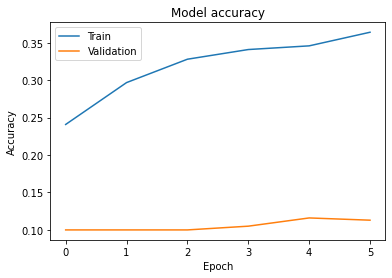

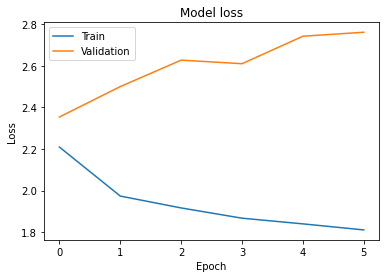

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: f1gvdpo8 with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0.2
wandb: 	fc_layer: 512
wandb: 	num_filters: [256, 128, 64, 32, 16]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_False_drop_0.2_fc_512_fil_[256, 128, 64, 32, 16]_shape_[[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
609530
Epoch 1/10


Run f1gvdpo8 errored: ResourceExhaustedError()
wandb: ERROR Run f1gvdpo8 errored: ResourceExhaustedError()
wandb: Agent Starting Run: cm9h18yg with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: True
wandb: 	dropout: 0.1
wandb: 	fc_layer: 128
wandb: 	num_filters: [32, 64, 128, 256, 512]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_True_drop_0.1_fc_128_fil_[32, 64, 128, 256, 512]_shape_[[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
3212362
Epoch 1/10
70/70 - 202s - loss: 2.2436 - accuracy: 0.2038 - val_loss: 2.3966 - val_accuracy: 0.1000
Epoch 2/10
70/70 - 199s - loss: 2.0686 - accuracy: 0.2619 - val_loss: 2.5579 - val_accuracy: 0.1000
Epoch 3/10
70/70 - 200s - loss: 2.0223 - accuracy: 0.2862 - val_loss: 2.7914 - val_accuracy: 0.0980
Epoch 4/10
70/70 - 199s - loss: 1.9846 - accuracy: 0.2938 - val_loss: 2.4418 - val_accuracy: 0.1050
Epoch 5/10
70/70 - 199s - loss: 1.9538 - accuracy: 0.3091 - val_loss: 2.3949 - val_accuracy: 0.1160
Epoch 6/10
70/70 - 199s - loss: 1.9275 - accuracy: 0.3210 - val_loss: 2.1708 - val_accuracy: 0.2180
Epoch 7/10
70/70 - 200s - loss: 1.9023 - accuracy: 0.3262 - val_loss: 2.0590 - val_accuracy: 0.2680
Epoch 8/10
70/70 - 199s - loss: 1.8805 - accurac

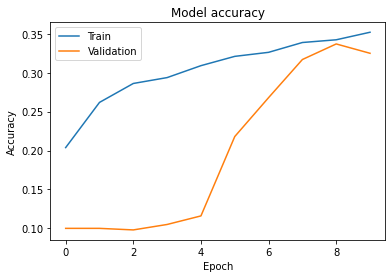

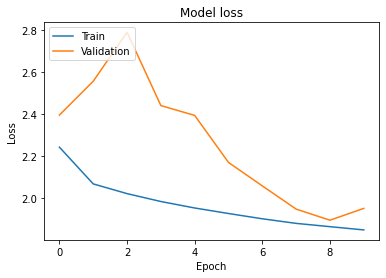

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: m2t1ea94 with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0.1
wandb: 	fc_layer: 128
wandb: 	num_filters: [32, 64, 128, 256, 512]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_False_drop_0.1_fc_128_fil_[32, 64, 128, 256, 512]_shape_[[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
3208394
Epoch 1/10
70/70 - 202s - loss: 2.2792 - accuracy: 0.1379 - val_loss: 2.2219 - val_accuracy: 0.1980
Epoch 2/10
70/70 - 202s - loss: 2.1752 - accuracy: 0.2005 - val_loss: 2.1201 - val_accuracy: 0.2440
Epoch 3/10
70/70 - 201s - loss: 2.0987 - accuracy: 0.2445 - val_loss: 2.1120 - val_accuracy: 0.2380
Epoch 4/10
70/70 - 209s - loss: 2.0731 - accuracy: 0.2560 - val_loss: 2.0367 - val_accuracy: 0.2970
Epoch 5/10
70/70 - 204s - loss: 2.0475 - accuracy: 0.2710 - val_loss: 2.0538 - val_accuracy: 0.2750
Epoch 6/10
70/70 - 202s - loss: 2.0256 - accuracy: 0.2849 - val_loss: 2.0160 - val_accuracy: 0.2920
Epoch 7/10
70/70 - 199s - loss: 2.0084 - accuracy: 0.2881 - val_loss: 1.9740 - val_accuracy: 0.3000
Epoch 8/10
70/70 - 201s - loss: 1.9954 - accura

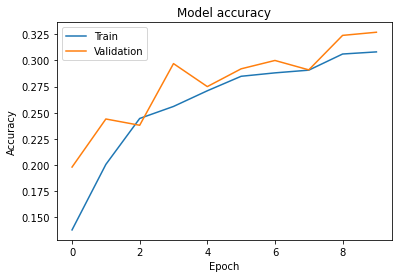

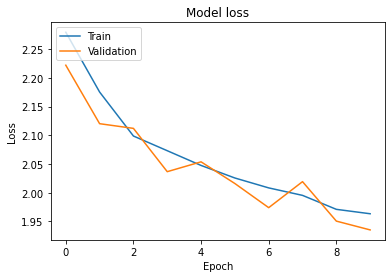

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: k217ov0k with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0
wandb: 	fc_layer: 128
wandb: 	num_filters: [256, 128, 64, 32, 16]
wandb: 	shape_of_filters_conv: [[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_False_drop_0_fc_128_fil_[256, 128, 64, 32, 16]_shape_[[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
988282
Epoch 1/10


Run k217ov0k errored: ResourceExhaustedError()
wandb: ERROR Run k217ov0k errored: ResourceExhaustedError()
wandb: Agent Starting Run: rxpq3jcg with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0.2
wandb: 	fc_layer: 128
wandb: 	num_filters: [32, 64, 128, 256, 512]
wandb: 	shape_of_filters_conv: [[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 256


aug_True_bs_256_bn_False_drop_0.2_fc_128_fil_[32, 64, 128, 256, 512]_shape_[[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
2655178
Epoch 1/10
35/35 - 208s - loss: 2.2797 - accuracy: 0.1459 - val_loss: 2.2433 - val_accuracy: 0.1670
Epoch 2/10
35/35 - 202s - loss: 2.2091 - accuracy: 0.1833 - val_loss: 2.1806 - val_accuracy: 0.2010
Epoch 3/10
35/35 - 201s - loss: 2.1576 - accuracy: 0.2073 - val_loss: 2.1446 - val_accuracy: 0.1970
Epoch 4/10
35/35 - 202s - loss: 2.1202 - accuracy: 0.2286 - val_loss: 2.0923 - val_accuracy: 0.2380
Epoch 5/10
35/35 - 200s - loss: 2.0969 - accuracy: 0.2468 - val_loss: 2.0635 - val_accuracy: 0.2600
Epoch 6/10
35/35 - 197s - loss: 2.0875 - accuracy: 0.2496 - val_loss: 2.0890 - val_accuracy: 0.2360
Epoch 7/10
35/35 - 201s - loss: 2.0642 - accuracy: 0.2599 - val_loss: 2.0199 - val_accuracy: 0.2870
Epoch 8/10
35/35 - 200s - loss: 2.0489 - accura

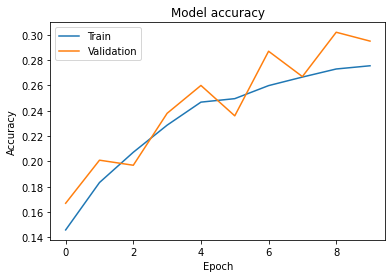

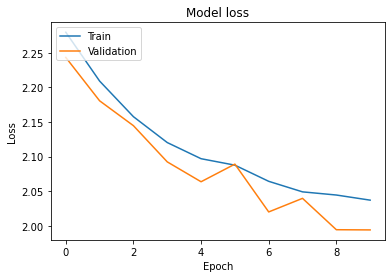

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 504kd0yu with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: True
wandb: 	dropout: 0.1
wandb: 	fc_layer: 512
wandb: 	num_filters: [32, 64, 128, 256, 512]
wandb: 	shape_of_filters_conv: [[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 256


aug_True_bs_256_bn_True_drop_0.1_fc_512_fil_[32, 64, 128, 256, 512]_shape_[[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
5809098
Epoch 1/10
35/35 - 204s - loss: 2.4418 - accuracy: 0.1907 - val_loss: 2.3148 - val_accuracy: 0.1070
Epoch 2/10
35/35 - 200s - loss: 2.0701 - accuracy: 0.2623 - val_loss: 2.3817 - val_accuracy: 0.1100
Epoch 3/10
35/35 - 202s - loss: 2.0171 - accuracy: 0.2833 - val_loss: 2.4170 - val_accuracy: 0.1120
Epoch 4/10
35/35 - 201s - loss: 2.0029 - accuracy: 0.2893 - val_loss: 2.5208 - val_accuracy: 0.1080
Epoch 5/10
35/35 - 201s - loss: 1.9611 - accuracy: 0.3066 - val_loss: 2.5000 - val_accuracy: 0.1170
Epoch 6/10
35/35 - 200s - loss: 1.9228 - accuracy: 0.3142 - val_loss: 2.6858 - val_accuracy: 0.0980


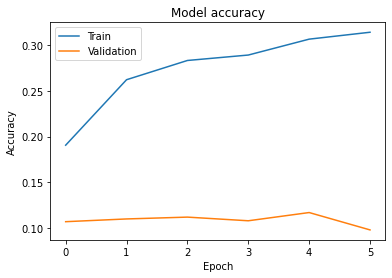

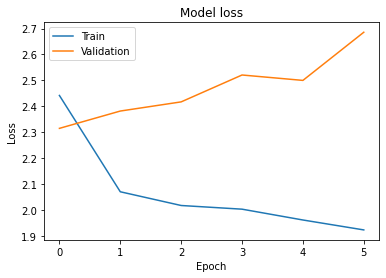

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: ylv2lppk with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0.2
wandb: 	fc_layer: 512
wandb: 	num_filters: [32, 64, 128, 256, 512]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_False_drop_0.2_fc_512_fil_[32, 64, 128, 256, 512]_shape_[[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
8389962
Epoch 1/10
70/70 - 202s - loss: 2.2261 - accuracy: 0.1750 - val_loss: 2.1849 - val_accuracy: 0.2110
Epoch 2/10
70/70 - 199s - loss: 2.1518 - accuracy: 0.2064 - val_loss: 2.1337 - val_accuracy: 0.2070
Epoch 3/10
70/70 - 200s - loss: 2.0992 - accuracy: 0.2367 - val_loss: 2.1153 - val_accuracy: 0.2460
Epoch 4/10
70/70 - 201s - loss: 2.0709 - accuracy: 0.2533 - val_loss: 2.0270 - val_accuracy: 0.2920
Epoch 5/10
70/70 - 198s - loss: 2.0314 - accuracy: 0.2780 - val_loss: 1.9975 - val_accuracy: 0.2960
Epoch 6/10
70/70 - 200s - loss: 1.9988 - accuracy: 0.2876 - val_loss: 1.9827 - val_accuracy: 0.3140
Epoch 7/10
70/70 - 199s - loss: 1.9772 - accuracy: 0.2928 - val_loss: 1.9392 - val_accuracy: 0.3140
Epoch 8/10
70/70 - 199s - loss: 1.9687 - accura

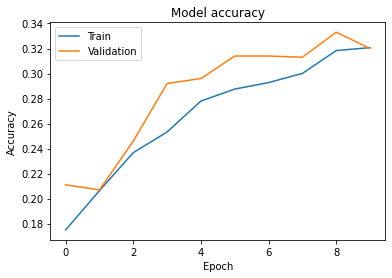

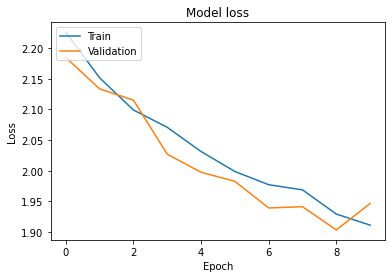

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: bsx1ub5m with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: True
wandb: 	dropout: 0
wandb: 	fc_layer: 256
wandb: 	num_filters: [32, 64, 128, 256, 512]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 256


aug_True_bs_256_bn_True_drop_0_fc_256_fil_[32, 64, 128, 256, 512]_shape_[[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
4852170
Epoch 1/10
35/35 - 203s - loss: 2.4167 - accuracy: 0.1926 - val_loss: 2.3177 - val_accuracy: 0.0970
Epoch 2/10
35/35 - 198s - loss: 2.0472 - accuracy: 0.2746 - val_loss: 2.4074 - val_accuracy: 0.1000
Epoch 3/10
35/35 - 199s - loss: 1.9795 - accuracy: 0.3007 - val_loss: 2.5154 - val_accuracy: 0.1100
Epoch 4/10
35/35 - 200s - loss: 1.9418 - accuracy: 0.3104 - val_loss: 2.5326 - val_accuracy: 0.1000
Epoch 5/10
35/35 - 199s - loss: 1.9043 - accuracy: 0.3283 - val_loss: 2.5293 - val_accuracy: 0.0980
Epoch 6/10
35/35 - 195s - loss: 1.8792 - accuracy: 0.3347 - val_loss: 2.5895 - val_accuracy: 0.1010


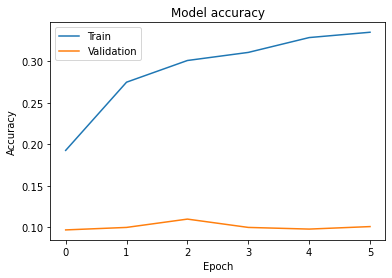

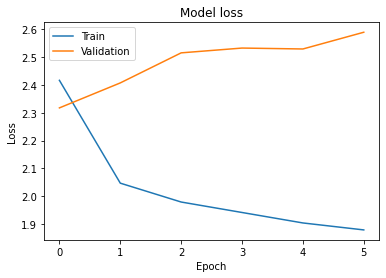

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: uo1teo4l with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0.2
wandb: 	fc_layer: 256
wandb: 	num_filters: [32, 64, 128, 256, 512]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 256


aug_True_bs_256_bn_False_drop_0.2_fc_256_fil_[32, 64, 128, 256, 512]_shape_[[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
4848202
Epoch 1/10
35/35 - 199s - loss: 2.2895 - accuracy: 0.1334 - val_loss: 2.2465 - val_accuracy: 0.1660
Epoch 2/10
35/35 - 196s - loss: 2.2053 - accuracy: 0.1940 - val_loss: 2.1557 - val_accuracy: 0.2060
Epoch 3/10
35/35 - 195s - loss: 2.1437 - accuracy: 0.2182 - val_loss: 2.1099 - val_accuracy: 0.2440
Epoch 4/10
35/35 - 196s - loss: 2.1153 - accuracy: 0.2378 - val_loss: 2.0726 - val_accuracy: 0.2530
Epoch 5/10
35/35 - 195s - loss: 2.0780 - accuracy: 0.2620 - val_loss: 2.0572 - val_accuracy: 0.2790
Epoch 6/10
35/35 - 195s - loss: 2.0586 - accuracy: 0.2607 - val_loss: 2.0313 - val_accuracy: 0.2800
Epoch 7/10
35/35 - 196s - loss: 2.0279 - accuracy: 0.2795 - val_loss: 1.9963 - val_accuracy: 0.3110
Epoch 8/10
35/35 - 197s - loss: 2.0263 - accura

In [ ]:
sweep_config = {
  "name": "Sweep 2 CS6910 Assignment 2 - Part A",
  "metric": {
      "name":"val_accuracy",
      "goal": "maximize"
  },
  "method": "random",
  "parameters": {
        "data_aug": {
            "values": [True]
        },
        "train_batch_size": {
            "values": [128, 256]
        },
        "batch_norm_use": {
            "values": [True, False]
        },
        "dropout": {
            "values": [0, 0.2, 0.1]
        },
        "num_filters": {
            "values": [[32, 64, 128, 256, 512],
                       [256, 128, 64, 32, 16]]
        },
        "fc_layer": {
            "values": [128, 256, 512]
        },
        "shape_of_filters_conv": {
            "values": [[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3)],
                       [(7, 7), (5, 5), (3, 3), (3, 3), (3, 3)],
                       [(3, 3), (3, 3), (3, 3), (5, 5), (7, 7)]]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, entity="ee17b154tony", project="dl_assignment_2")
wandb.agent(sweep_id, train_validate_model_wandb, count=25)

Create sweep with ID: w8smkyki
Sweep URL: https://wandb.ai/ee17b154tony/dl_assignment_2/sweeps/w8smkyki


wandb: Agent Starting Run: hyvyed36 with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: True
wandb: 	dropout: 0
wandb: 	fc_layer: 512
wandb: 	num_filters: [128, 64, 32, 16, 8]
wandb: 	shape_of_filters_conv: [[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_True_drop_0_fc_512_fil_[128, 64, 32, 16, 8]_shape_[[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
320226
Epoch 1/10
70/70 - 230s - loss: 2.2718 - accuracy: 0.1571 - val_loss: 2.3116 - val_accuracy: 0.1020
Epoch 2/10
70/70 - 206s - loss: 2.1484 - accuracy: 0.2126 - val_loss: 2.3804 - val_accuracy: 0.1000
Epoch 3/10
70/70 - 203s - loss: 2.1034 - accuracy: 0.2363 - val_loss: 2.4700 - val_accuracy: 0.1000
Epoch 4/10
70/70 - 204s - loss: 2.0779 - accuracy: 0.2435 - val_loss: 2.4850 - val_accuracy: 0.1030
Epoch 5/10
70/70 - 203s - loss: 2.0538 - accuracy: 0.2577 - val_loss: 2.5101 - val_accuracy: 0.1040
Epoch 6/10
70/70 - 205s - loss: 2.0367 - accuracy: 0.2628 - val_loss: 2.3485 - val_accuracy: 0.1640


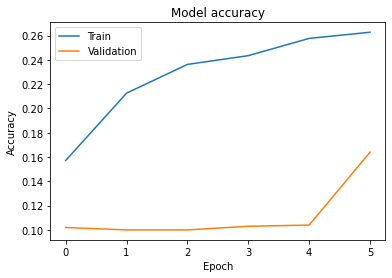

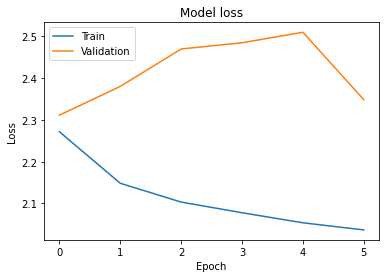

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: uj0fz5np with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: True
wandb: 	dropout: 0
wandb: 	fc_layer: 128
wandb: 	num_filters: [128, 64, 32, 16, 8]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_True_drop_0_fc_128_fil_[128, 64, 32, 16, 8]_shape_[[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
129634
Epoch 1/10
70/70 - 210s - loss: 2.3852 - accuracy: 0.1370 - val_loss: 2.3054 - val_accuracy: 0.1190
Epoch 2/10
70/70 - 203s - loss: 2.2234 - accuracy: 0.1869 - val_loss: 2.3129 - val_accuracy: 0.1000
Epoch 3/10
70/70 - 202s - loss: 2.1654 - accuracy: 0.2140 - val_loss: 2.3380 - val_accuracy: 0.1040
Epoch 4/10
70/70 - 203s - loss: 2.1395 - accuracy: 0.2246 - val_loss: 2.3953 - val_accuracy: 0.0980
Epoch 5/10
70/70 - 201s - loss: 2.1070 - accuracy: 0.2384 - val_loss: 2.4995 - val_accuracy: 0.1110
Epoch 6/10
70/70 - 202s - loss: 2.0923 - accuracy: 0.2417 - val_loss: 2.5554 - val_accuracy: 0.1050


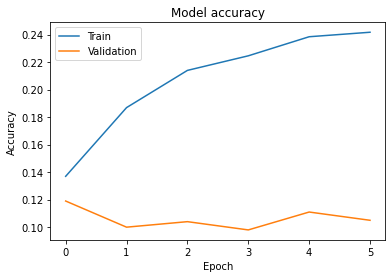

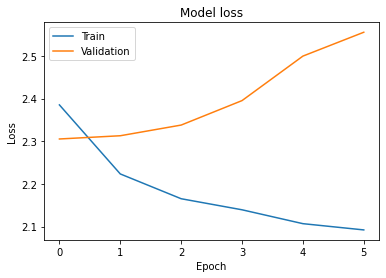

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: n0defutn with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: True
wandb: 	dropout: 0.1
wandb: 	fc_layer: 128
wandb: 	num_filters: [64, 128, 256, 512, 1024]
wandb: 	shape_of_filters_conv: [[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_True_drop_0.1_fc_128_fil_[64, 128, 256, 512, 1024]_shape_[[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
8515850
Epoch 1/10
70/70 - 219s - loss: 2.2680 - accuracy: 0.2090 - val_loss: 2.4121 - val_accuracy: 0.1040
Epoch 2/10
70/70 - 204s - loss: 2.0807 - accuracy: 0.2477 - val_loss: 2.5440 - val_accuracy: 0.1000
Epoch 3/10
70/70 - 204s - loss: 2.0531 - accuracy: 0.2680 - val_loss: 2.6559 - val_accuracy: 0.1000
Epoch 4/10
70/70 - 203s - loss: 2.0071 - accuracy: 0.2834 - val_loss: 2.7562 - val_accuracy: 0.1070
Epoch 5/10
70/70 - 204s - loss: 2.0007 - accuracy: 0.2843 - val_loss: 2.2701 - val_accuracy: 0.1690
Epoch 6/10
70/70 - 205s - loss: 1.9706 - accuracy: 0.2999 - val_loss: 2.4224 - val_accuracy: 0.1570
Epoch 7/10
70/70 - 204s - loss: 1.9694 - accuracy: 0.2996 - val_loss: 2.1073 - val_accuracy: 0.2400
Epoch 8/10
70/70 - 204s - loss: 1.9447 - accur

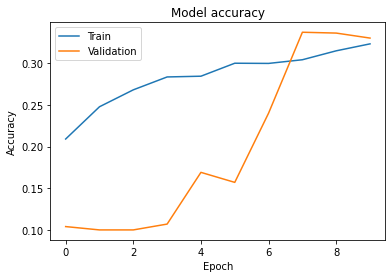

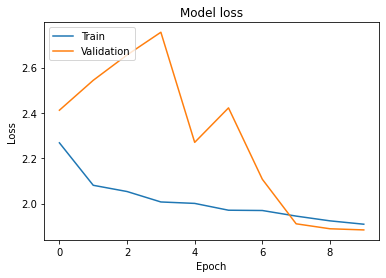

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: mjicshhr with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0.1
wandb: 	fc_layer: 256
wandb: 	num_filters: [64, 128, 256, 512, 1024]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_False_drop_0.1_fc_256_fil_[64, 128, 256, 512, 1024]_shape_[[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
30390666
Epoch 1/10
70/70 - 226s - loss: 2.2559 - accuracy: 0.1521 - val_loss: 2.2257 - val_accuracy: 0.1610
Epoch 2/10
70/70 - 204s - loss: 2.1669 - accuracy: 0.1990 - val_loss: 2.1098 - val_accuracy: 0.2230
Epoch 3/10
70/70 - 205s - loss: 2.1208 - accuracy: 0.2253 - val_loss: 2.0377 - val_accuracy: 0.2770
Epoch 4/10
70/70 - 204s - loss: 2.0784 - accuracy: 0.2527 - val_loss: 1.9853 - val_accuracy: 0.3040
Epoch 5/10
70/70 - 204s - loss: 2.0323 - accuracy: 0.2723 - val_loss: 2.0515 - val_accuracy: 0.2710
Epoch 6/10
70/70 - 205s - loss: 2.0092 - accuracy: 0.2825 - val_loss: 1.9438 - val_accuracy: 0.3220
Epoch 7/10
70/70 - 201s - loss: 1.9852 - accuracy: 0.2928 - val_loss: 1.9122 - val_accuracy: 0.3310
Epoch 8/10
70/70 - 205s - loss: 1.9569 - acc

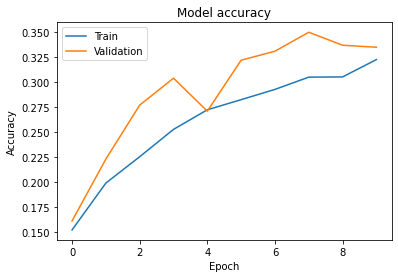

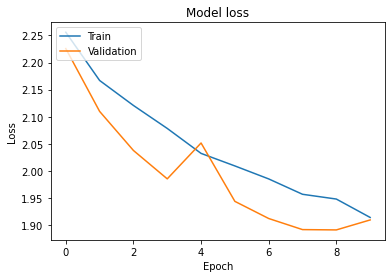

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: j7my0xad with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0
wandb: 	fc_layer: 128
wandb: 	num_filters: [32, 64, 128, 256, 512]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_False_drop_0_fc_128_fil_[32, 64, 128, 256, 512]_shape_[[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
3208394
Epoch 1/10
70/70 - 205s - loss: 2.2613 - accuracy: 0.1545 - val_loss: 2.1786 - val_accuracy: 0.1940
Epoch 2/10
70/70 - 198s - loss: 2.1536 - accuracy: 0.2168 - val_loss: 2.1700 - val_accuracy: 0.2050
Epoch 3/10
70/70 - 194s - loss: 2.1012 - accuracy: 0.2383 - val_loss: 2.0318 - val_accuracy: 0.2820
Epoch 4/10
70/70 - 198s - loss: 2.0561 - accuracy: 0.2642 - val_loss: 1.9882 - val_accuracy: 0.3010
Epoch 5/10
70/70 - 198s - loss: 2.0302 - accuracy: 0.2736 - val_loss: 1.9637 - val_accuracy: 0.3040
Epoch 6/10
70/70 - 199s - loss: 2.0092 - accuracy: 0.2862 - val_loss: 1.9749 - val_accuracy: 0.3120
Epoch 7/10
70/70 - 197s - loss: 1.9941 - accuracy: 0.2886 - val_loss: 1.9181 - val_accuracy: 0.3370
Epoch 8/10
70/70 - 199s - loss: 1.9644 - accuracy

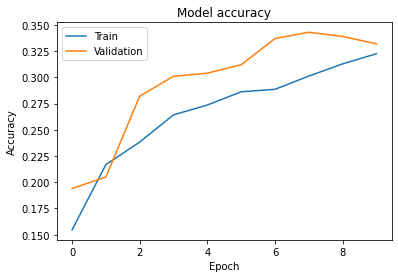

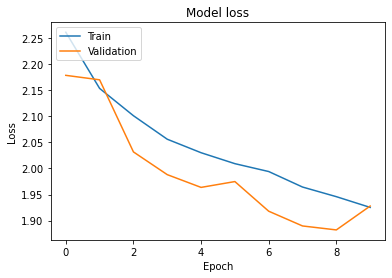

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: e9mmmbll with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: True
wandb: 	dropout: 0.1
wandb: 	fc_layer: 128
wandb: 	num_filters: [128, 64, 32, 16, 8]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_True_drop_0.1_fc_128_fil_[128, 64, 32, 16, 8]_shape_[[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
129634
Epoch 1/10
70/70 - 206s - loss: 2.4010 - accuracy: 0.1337 - val_loss: 2.3229 - val_accuracy: 0.1000
Epoch 2/10
70/70 - 205s - loss: 2.2424 - accuracy: 0.1800 - val_loss: 2.3648 - val_accuracy: 0.1000
Epoch 3/10
70/70 - 204s - loss: 2.1930 - accuracy: 0.2005 - val_loss: 2.3763 - val_accuracy: 0.1030
Epoch 4/10
70/70 - 205s - loss: 2.1553 - accuracy: 0.2204 - val_loss: 2.4176 - val_accuracy: 0.1180
Epoch 5/10
70/70 - 209s - loss: 2.1297 - accuracy: 0.2274 - val_loss: 2.4311 - val_accuracy: 0.1200
Epoch 6/10
70/70 - 210s - loss: 2.1083 - accuracy: 0.2355 - val_loss: 2.3505 - val_accuracy: 0.1480


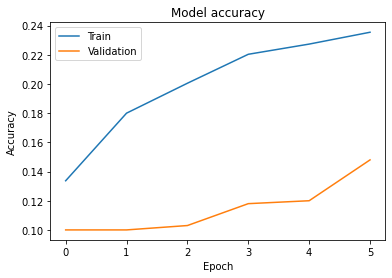

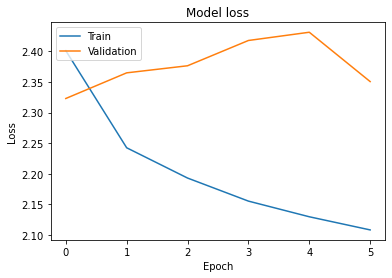

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 97u22h1r with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0
wandb: 	fc_layer: 512
wandb: 	num_filters: [64, 128, 256, 512, 1024]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_False_drop_0_fc_512_fil_[64, 128, 256, 512, 1024]_shape_[[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
31442058
Epoch 1/10
70/70 - 207s - loss: 2.2331 - accuracy: 0.1600 - val_loss: 2.1384 - val_accuracy: 0.2200
Epoch 2/10
70/70 - 211s - loss: 2.1292 - accuracy: 0.2171 - val_loss: 2.0737 - val_accuracy: 0.2360
Epoch 3/10
70/70 - 206s - loss: 2.0858 - accuracy: 0.2477 - val_loss: 2.0298 - val_accuracy: 0.2810
Epoch 4/10
70/70 - 202s - loss: 2.0425 - accuracy: 0.2641 - val_loss: 1.9785 - val_accuracy: 0.3270
Epoch 5/10
70/70 - 205s - loss: 2.0158 - accuracy: 0.2763 - val_loss: 1.9615 - val_accuracy: 0.3190
Epoch 6/10
70/70 - 204s - loss: 1.9861 - accuracy: 0.2879 - val_loss: 1.8866 - val_accuracy: 0.3380
Epoch 7/10
70/70 - 206s - loss: 1.9575 - accuracy: 0.3062 - val_loss: 1.9136 - val_accuracy: 0.3500
Epoch 8/10
70/70 - 205s - loss: 1.9228 - accur

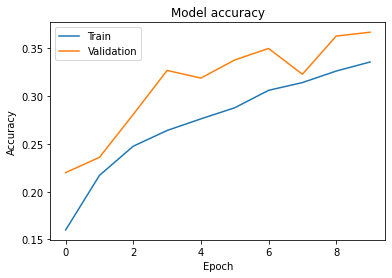

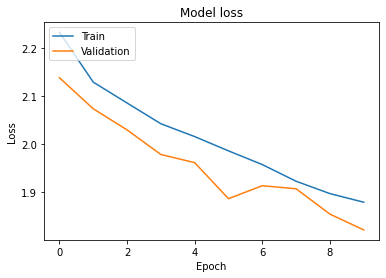

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 89l86gsu with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0.2
wandb: 	fc_layer: 256
wandb: 	num_filters: [64, 128, 256, 512, 1024]
wandb: 	shape_of_filters_conv: [[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_False_drop_0.2_fc_256_fil_[64, 128, 256, 512, 1024]_shape_[[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
10606474
Epoch 1/10
70/70 - 214s - loss: 2.2488 - accuracy: 0.1547 - val_loss: 2.1683 - val_accuracy: 0.2050
Epoch 2/10
70/70 - 204s - loss: 2.1584 - accuracy: 0.2101 - val_loss: 2.0680 - val_accuracy: 0.2750
Epoch 3/10
70/70 - 223s - loss: 2.1152 - accuracy: 0.2328 - val_loss: 2.0432 - val_accuracy: 0.2540
Epoch 4/10
70/70 - 208s - loss: 2.0981 - accuracy: 0.2482 - val_loss: 1.9956 - val_accuracy: 0.2900
Epoch 5/10
70/70 - 216s - loss: 2.0599 - accuracy: 0.2567 - val_loss: 2.0018 - val_accuracy: 0.2940
Epoch 6/10
70/70 - 219s - loss: 2.0383 - accuracy: 0.2726 - val_loss: 1.9525 - val_accuracy: 0.3240
Epoch 7/10
70/70 - 214s - loss: 2.0036 - accuracy: 0.2907 - val_loss: 1.9314 - val_accuracy: 0.3190
Epoch 8/10
70/70 - 215s - loss: 2.0142 - acc

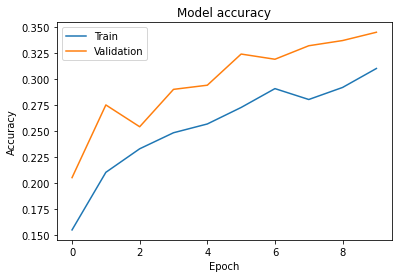

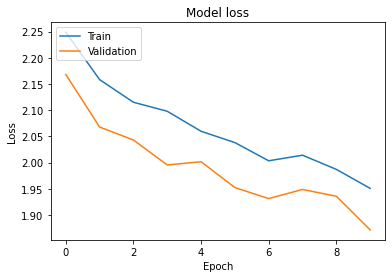

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: q8olnhfu with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0.2
wandb: 	fc_layer: 128
wandb: 	num_filters: [64, 128, 256, 512, 1024]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_False_drop_0.2_fc_128_fil_[64, 128, 256, 512, 1024]_shape_[[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
9548810
Epoch 1/10
70/70 - 212s - loss: 2.2740 - accuracy: 0.1383 - val_loss: 2.2319 - val_accuracy: 0.1620
Epoch 2/10
70/70 - 207s - loss: 2.1812 - accuracy: 0.1959 - val_loss: 2.0893 - val_accuracy: 0.2420
Epoch 3/10
70/70 - 203s - loss: 2.1263 - accuracy: 0.2252 - val_loss: 2.0534 - val_accuracy: 0.2880
Epoch 4/10
70/70 - 204s - loss: 2.0882 - accuracy: 0.2483 - val_loss: 2.0395 - val_accuracy: 0.2810
Epoch 5/10
70/70 - 202s - loss: 2.0667 - accuracy: 0.2642 - val_loss: 2.0244 - val_accuracy: 0.2940
Epoch 6/10
70/70 - 201s - loss: 2.0467 - accuracy: 0.2678 - val_loss: 1.9803 - val_accuracy: 0.3020
Epoch 7/10
70/70 - 202s - loss: 2.0251 - accuracy: 0.2775 - val_loss: 1.9713 - val_accuracy: 0.3060
Epoch 8/10
70/70 - 200s - loss: 2.0091 - accu

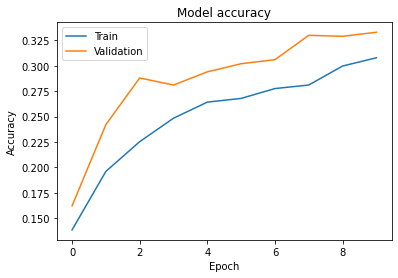

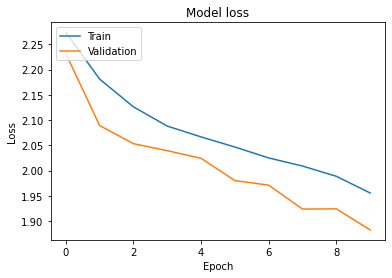

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: nmnov7ic with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: True
wandb: 	dropout: 0.2
wandb: 	fc_layer: 256
wandb: 	num_filters: [64, 128, 256, 512, 1024]
wandb: 	shape_of_filters_conv: [[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_True_drop_0.2_fc_256_fil_[64, 128, 256, 512, 1024]_shape_[[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
10614410
Epoch 1/10
70/70 - 208s - loss: 2.3185 - accuracy: 0.2031 - val_loss: 2.3437 - val_accuracy: 0.1020
Epoch 2/10
70/70 - 205s - loss: 2.1062 - accuracy: 0.2474 - val_loss: 2.4084 - val_accuracy: 0.1000
Epoch 3/10
70/70 - 206s - loss: 2.0694 - accuracy: 0.2628 - val_loss: 2.5365 - val_accuracy: 0.1350
Epoch 4/10
70/70 - 207s - loss: 2.0353 - accuracy: 0.2747 - val_loss: 2.4879 - val_accuracy: 0.1450
Epoch 5/10
70/70 - 207s - loss: 2.0185 - accuracy: 0.2783 - val_loss: 2.3200 - val_accuracy: 0.1530
Epoch 6/10
70/70 - 206s - loss: 1.9909 - accuracy: 0.2997 - val_loss: 2.2475 - val_accuracy: 0.1880
Epoch 7/10
70/70 - 208s - loss: 1.9606 - accuracy: 0.2914 - val_loss: 2.0172 - val_accuracy: 0.2970
Epoch 8/10
70/70 - 205s - loss: 1.9400 - accu

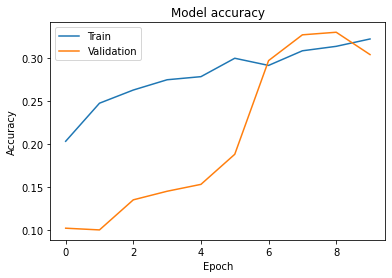

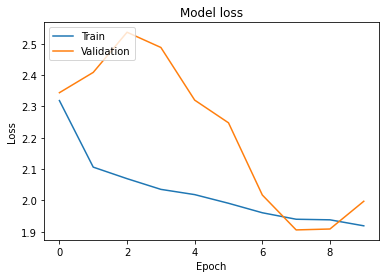

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 9n1g2vj4 with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0
wandb: 	fc_layer: 512
wandb: 	num_filters: [128, 64, 32, 16, 8]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_False_drop_0_fc_512_fil_[128, 64, 32, 16, 8]_shape_[[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
136962
Epoch 1/10
70/70 - 205s - loss: 2.3008 - accuracy: 0.1101 - val_loss: 2.2914 - val_accuracy: 0.1050
Epoch 2/10
70/70 - 201s - loss: 2.2571 - accuracy: 0.1468 - val_loss: 2.2715 - val_accuracy: 0.1600
Epoch 3/10
70/70 - 200s - loss: 2.2176 - accuracy: 0.1773 - val_loss: 2.2015 - val_accuracy: 0.1980
Epoch 4/10
70/70 - 200s - loss: 2.1846 - accuracy: 0.1934 - val_loss: 2.1359 - val_accuracy: 0.2070
Epoch 5/10
70/70 - 199s - loss: 2.1597 - accuracy: 0.1992 - val_loss: 2.1377 - val_accuracy: 0.2240
Epoch 6/10
70/70 - 200s - loss: 2.1547 - accuracy: 0.2040 - val_loss: 2.1216 - val_accuracy: 0.2290
Epoch 7/10
70/70 - 201s - loss: 2.1421 - accuracy: 0.2091 - val_loss: 2.1052 - val_accuracy: 0.2250
Epoch 8/10
70/70 - 201s - loss: 2.1326 - accuracy: 0.

In [ ]:
sweep_config = {
  "name": "Sweep 2 CS6910 Assignment 2 - Part A",
  "metric": {
      "name":"val_accuracy",
      "goal": "maximize"
  },
  "method": "random",
  "parameters": {
        "data_aug": {
            "values": [True]
        },
        "train_batch_size": {
            "values": [128]
        },
        "batch_norm_use": {
            "values": [True, False]
        },
        "dropout": {
            "values": [0, 0.2, 0.1]
        },
        "num_filters": {
            "values": [[32, 64, 128, 256, 512],
                       [128, 64, 32, 16, 8], [64, 128, 256, 512, 1024]]
        },
        "fc_layer": {
            "values": [128, 256, 512]
        },
        "shape_of_filters_conv": {
            "values": [[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3)],
                       [(7, 7), (5, 5), (3, 3), (3, 3), (3, 3)],
                       [(3, 3), (3, 3), (3, 3), (5, 5), (7, 7)]]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, entity="ee17b154tony", project="dl_assignment_2")
wandb.agent(sweep_id, train_validate_model_wandb, count=25)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: nel8vg2t
Sweep URL: https://wandb.ai/ee17b154tony/dl_assignment_2/sweeps/nel8vg2t


wandb: Agent Starting Run: dp3gp58c with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0.2
wandb: 	fc_layer: 256
wandb: 	num_filters: [32, 64, 128, 256, 512]
wandb: 	shape_of_filters_conv: [[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128
wandb: Currently logged in as: ee17b154tony (use `wandb login --relogin` to force relogin)


aug_True_bs_128_bn_False_drop_0.2_fc_256_fil_[32, 64, 128, 256, 512]_shape_[[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
3705162
Epoch 1/10
70/70 - 244s - loss: 2.2787 - accuracy: 0.1393 - val_loss: 2.2109 - val_accuracy: 0.1770
Epoch 2/10
70/70 - 204s - loss: 2.1746 - accuracy: 0.2017 - val_loss: 2.1452 - val_accuracy: 0.2200
Epoch 3/10
70/70 - 197s - loss: 2.1257 - accuracy: 0.2332 - val_loss: 2.1161 - val_accuracy: 0.2300
Epoch 4/10
70/70 - 198s - loss: 2.0887 - accuracy: 0.2513 - val_loss: 2.0877 - val_accuracy: 0.2640
Epoch 5/10
70/70 - 197s - loss: 2.0695 - accuracy: 0.2568 - val_loss: 2.0199 - val_accuracy: 0.2960
Epoch 6/10
70/70 - 198s - loss: 2.0450 - accuracy: 0.2693 - val_loss: 2.0034 - val_accuracy: 0.2810
Epoch 7/10
70/70 - 198s - loss: 2.0309 - accuracy: 0.2744 - val_loss: 1.9809 - val_accuracy: 0.2990
Epoch 8/10
70/70 - 198s - loss: 2.0110 - accura

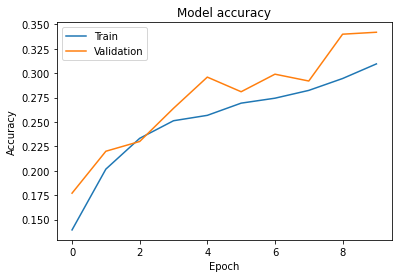

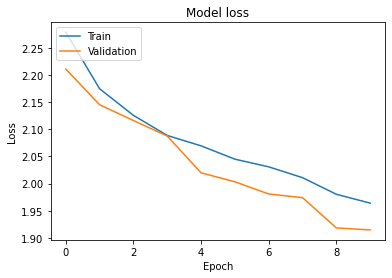

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: yu2iypb3 with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: True
wandb: 	dropout: 0.1
wandb: 	fc_layer: 128
wandb: 	num_filters: [128, 64, 32, 16, 8]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_True_drop_0.1_fc_128_fil_[128, 64, 32, 16, 8]_shape_[[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
129634
Epoch 1/10
70/70 - 208s - loss: 2.4848 - accuracy: 0.1202 - val_loss: 2.3111 - val_accuracy: 0.1000
Epoch 2/10
70/70 - 200s - loss: 2.2879 - accuracy: 0.1620 - val_loss: 2.3221 - val_accuracy: 0.1060
Epoch 3/10
70/70 - 202s - loss: 2.2247 - accuracy: 0.1852 - val_loss: 2.3419 - val_accuracy: 0.1290
Epoch 4/10
70/70 - 201s - loss: 2.1871 - accuracy: 0.2070 - val_loss: 2.3723 - val_accuracy: 0.1080
Epoch 5/10
70/70 - 201s - loss: 2.1467 - accuracy: 0.2206 - val_loss: 2.4079 - val_accuracy: 0.1210
Epoch 6/10
70/70 - 203s - loss: 2.1195 - accuracy: 0.2283 - val_loss: 2.4512 - val_accuracy: 0.1230


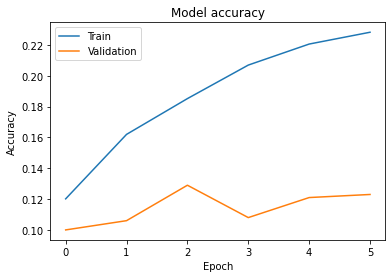

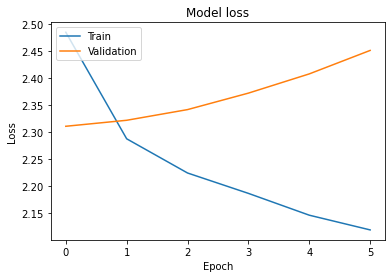

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: p6wsks6c with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0
wandb: 	fc_layer: 256
wandb: 	num_filters: [32, 64, 128, 256, 512]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_False_drop_0_fc_256_fil_[32, 64, 128, 256, 512]_shape_[[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
7862858
Epoch 1/10
70/70 - 203s - loss: 2.2754 - accuracy: 0.1425 - val_loss: 2.2259 - val_accuracy: 0.1490
Epoch 2/10
70/70 - 197s - loss: 2.1631 - accuracy: 0.2069 - val_loss: 2.1688 - val_accuracy: 0.2150
Epoch 3/10
70/70 - 198s - loss: 2.0953 - accuracy: 0.2398 - val_loss: 2.0836 - val_accuracy: 0.2610
Epoch 4/10
70/70 - 196s - loss: 2.0596 - accuracy: 0.2628 - val_loss: 1.9934 - val_accuracy: 0.3000
Epoch 5/10
70/70 - 196s - loss: 2.0336 - accuracy: 0.2719 - val_loss: 2.0262 - val_accuracy: 0.2810
Epoch 6/10
70/70 - 197s - loss: 2.0087 - accuracy: 0.2887 - val_loss: 1.9593 - val_accuracy: 0.2990
Epoch 7/10
70/70 - 196s - loss: 1.9985 - accuracy: 0.2820 - val_loss: 1.9448 - val_accuracy: 0.3310
Epoch 8/10
70/70 - 196s - loss: 1.9712 - accuracy

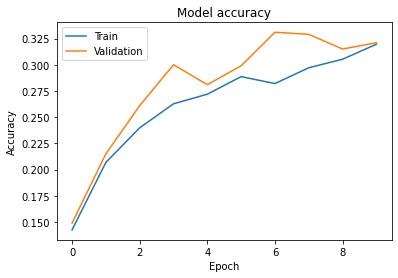

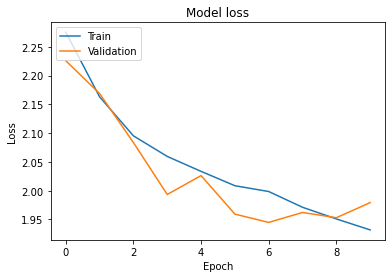

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 2vjywv6j with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0.2
wandb: 	fc_layer: 512
wandb: 	num_filters: [64, 128, 256, 512, 1024]
wandb: 	shape_of_filters_conv: [[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_False_drop_0.2_fc_512_fil_[64, 128, 256, 512, 1024]_shape_[[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
14803594
Epoch 1/10
70/70 - 218s - loss: 2.2658 - accuracy: 0.1408 - val_loss: 2.1848 - val_accuracy: 0.1980
Epoch 2/10
70/70 - 200s - loss: 2.1567 - accuracy: 0.2069 - val_loss: 2.1990 - val_accuracy: 0.1950
Epoch 3/10
70/70 - 200s - loss: 2.1208 - accuracy: 0.2317 - val_loss: 2.0928 - val_accuracy: 0.2370
Epoch 4/10
70/70 - 199s - loss: 2.0823 - accuracy: 0.2512 - val_loss: 2.0251 - val_accuracy: 0.2520
Epoch 5/10
70/70 - 200s - loss: 2.0484 - accuracy: 0.2707 - val_loss: 1.9935 - val_accuracy: 0.3000
Epoch 6/10
70/70 - 198s - loss: 2.0263 - accuracy: 0.2811 - val_loss: 1.9764 - val_accuracy: 0.3160
Epoch 7/10
70/70 - 199s - loss: 1.9991 - accuracy: 0.2877 - val_loss: 1.9426 - val_accuracy: 0.3210
Epoch 8/10
70/70 - 199s - loss: 1.9847 - acc

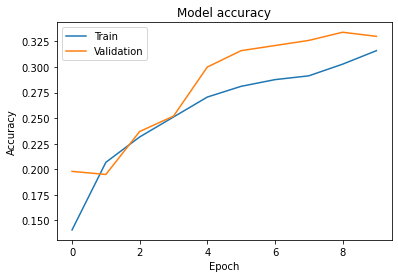

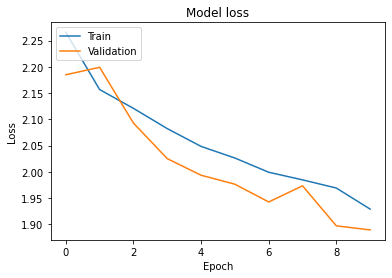

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: usqww4u2 with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0
wandb: 	fc_layer: 512
wandb: 	num_filters: [128, 64, 32, 16, 8]
wandb: 	shape_of_filters_conv: [[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_False_drop_0_fc_512_fil_[128, 64, 32, 16, 8]_shape_[[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
319234
Epoch 1/10
70/70 - 208s - loss: 2.3008 - accuracy: 0.1117 - val_loss: 2.2951 - val_accuracy: 0.1070
Epoch 2/10
70/70 - 198s - loss: 2.2556 - accuracy: 0.1606 - val_loss: 2.2179 - val_accuracy: 0.1790
Epoch 3/10
70/70 - 199s - loss: 2.1859 - accuracy: 0.1907 - val_loss: 2.1567 - val_accuracy: 0.2040
Epoch 4/10
70/70 - 198s - loss: 2.1626 - accuracy: 0.1967 - val_loss: 2.1397 - val_accuracy: 0.2190
Epoch 5/10
70/70 - 197s - loss: 2.1418 - accuracy: 0.2099 - val_loss: 2.1368 - val_accuracy: 0.2220
Epoch 6/10
70/70 - 198s - loss: 2.1181 - accuracy: 0.2227 - val_loss: 2.1070 - val_accuracy: 0.2280
Epoch 7/10
70/70 - 199s - loss: 2.1062 - accuracy: 0.2288 - val_loss: 2.1257 - val_accuracy: 0.2310
Epoch 8/10
70/70 - 210s - loss: 2.0884 - accuracy: 0.

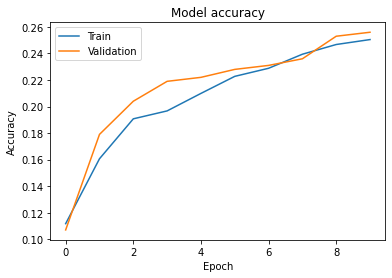

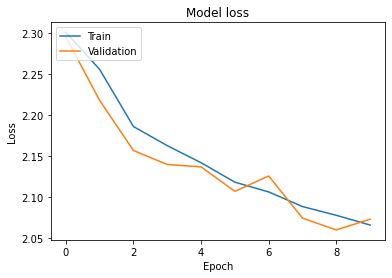

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 9orapq7l with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0
wandb: 	fc_layer: 256
wandb: 	num_filters: [32, 64, 128, 256, 512]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_False_drop_0_fc_256_fil_[32, 64, 128, 256, 512]_shape_[[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
4848202
Epoch 1/10
70/70 - 204s - loss: 2.2571 - accuracy: 0.1553 - val_loss: 2.1918 - val_accuracy: 0.1910
Epoch 2/10
70/70 - 201s - loss: 2.1457 - accuracy: 0.2184 - val_loss: 2.1028 - val_accuracy: 0.2380
Epoch 3/10
70/70 - 201s - loss: 2.0821 - accuracy: 0.2513 - val_loss: 2.0563 - val_accuracy: 0.2760
Epoch 4/10
70/70 - 202s - loss: 2.0480 - accuracy: 0.2692 - val_loss: 2.0077 - val_accuracy: 0.2880
Epoch 5/10
70/70 - 200s - loss: 2.0115 - accuracy: 0.2886 - val_loss: 1.9462 - val_accuracy: 0.3140
Epoch 6/10
70/70 - 199s - loss: 1.9815 - accuracy: 0.2960 - val_loss: 1.9691 - val_accuracy: 0.3060
Epoch 7/10
70/70 - 199s - loss: 1.9665 - accuracy: 0.3022 - val_loss: 1.9440 - val_accuracy: 0.3140
Epoch 8/10
70/70 - 199s - loss: 1.9523 - accuracy

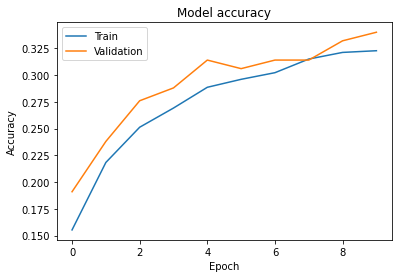

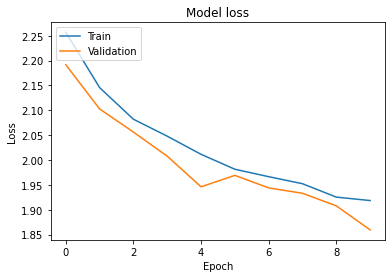

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: irsvcubo with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: True
wandb: 	dropout: 0.2
wandb: 	fc_layer: 256
wandb: 	num_filters: [128, 64, 32, 16, 8]
wandb: 	shape_of_filters_conv: [[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_True_drop_0.2_fc_256_fil_[128, 64, 32, 16, 8]_shape_[[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
284642
Epoch 1/10
70/70 - 209s - loss: 2.3650 - accuracy: 0.1394 - val_loss: 2.3072 - val_accuracy: 0.1000
Epoch 2/10
70/70 - 208s - loss: 2.2474 - accuracy: 0.1751 - val_loss: 2.3088 - val_accuracy: 0.1110
Epoch 3/10
70/70 - 208s - loss: 2.2008 - accuracy: 0.1993 - val_loss: 2.3167 - val_accuracy: 0.1190
Epoch 4/10
70/70 - 208s - loss: 2.1576 - accuracy: 0.2171 - val_loss: 2.3059 - val_accuracy: 0.1290
Epoch 5/10
70/70 - 207s - loss: 2.1374 - accuracy: 0.2226 - val_loss: 2.3042 - val_accuracy: 0.1360
Epoch 6/10
70/70 - 211s - loss: 2.1073 - accuracy: 0.2312 - val_loss: 2.2253 - val_accuracy: 0.1700
Epoch 7/10
70/70 - 210s - loss: 2.0892 - accuracy: 0.2456 - val_loss: 2.1984 - val_accuracy: 0.1780
Epoch 8/10
70/70 - 209s - loss: 2.0745 - accuracy: 0

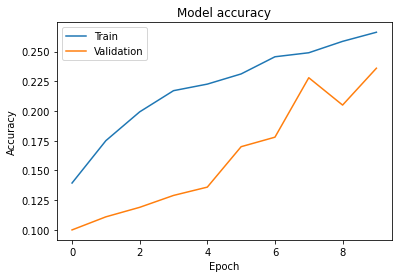

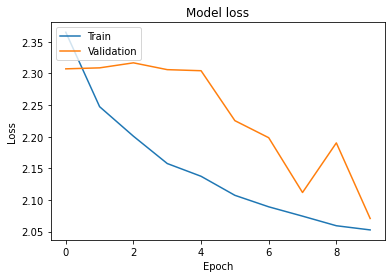

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: ofjqt2fd with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0.1
wandb: 	fc_layer: 256
wandb: 	num_filters: [32, 64, 128, 256, 512]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_False_drop_0.1_fc_256_fil_[32, 64, 128, 256, 512]_shape_[[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
4848202
Epoch 1/10
70/70 - 203s - loss: 2.2769 - accuracy: 0.1307 - val_loss: 2.2303 - val_accuracy: 0.1660
Epoch 2/10
70/70 - 200s - loss: 2.1833 - accuracy: 0.2021 - val_loss: 2.1123 - val_accuracy: 0.2490
Epoch 3/10
70/70 - 197s - loss: 2.1074 - accuracy: 0.2398 - val_loss: 2.0741 - val_accuracy: 0.2730
Epoch 4/10
70/70 - 196s - loss: 2.0655 - accuracy: 0.2656 - val_loss: 2.0650 - val_accuracy: 0.2700
Epoch 5/10
70/70 - 199s - loss: 2.0490 - accuracy: 0.2670 - val_loss: 1.9791 - val_accuracy: 0.2910
Epoch 6/10
70/70 - 200s - loss: 2.0218 - accuracy: 0.2819 - val_loss: 1.9553 - val_accuracy: 0.3210
Epoch 7/10
70/70 - 197s - loss: 1.9934 - accuracy: 0.2953 - val_loss: 1.9547 - val_accuracy: 0.3090
Epoch 8/10
70/70 - 197s - loss: 1.9729 - accura

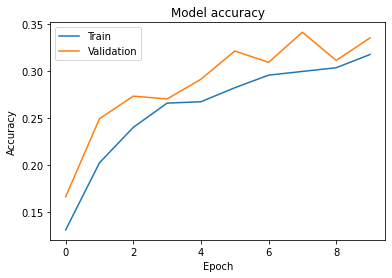

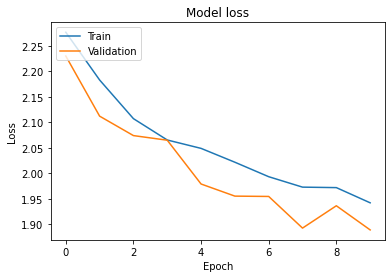

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 29a0b3hm with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: True
wandb: 	dropout: 0.1
wandb: 	fc_layer: 256
wandb: 	num_filters: [64, 128, 256, 512, 1024]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_True_drop_0.1_fc_256_fil_[64, 128, 256, 512, 1024]_shape_[[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
30398602
Epoch 1/10
70/70 - 217s - loss: 2.2196 - accuracy: 0.2354 - val_loss: 2.5816 - val_accuracy: 0.1000
Epoch 2/10
70/70 - 208s - loss: 1.9913 - accuracy: 0.2931 - val_loss: 2.9467 - val_accuracy: 0.1000
Epoch 3/10
70/70 - 208s - loss: 1.9269 - accuracy: 0.3104 - val_loss: 2.4581 - val_accuracy: 0.1020
Epoch 4/10
70/70 - 212s - loss: 1.8737 - accuracy: 0.3398 - val_loss: 2.8993 - val_accuracy: 0.0990
Epoch 5/10
70/70 - 211s - loss: 1.8200 - accuracy: 0.3546 - val_loss: 2.4024 - val_accuracy: 0.1450
Epoch 6/10
70/70 - 214s - loss: 1.8023 - accuracy: 0.3656 - val_loss: 2.2898 - val_accuracy: 0.1920
Epoch 7/10
70/70 - 210s - loss: 1.7640 - accuracy: 0.3782 - val_loss: 2.2006 - val_accuracy: 0.2460
Epoch 8/10
70/70 - 203s - loss: 1.7396 - accu

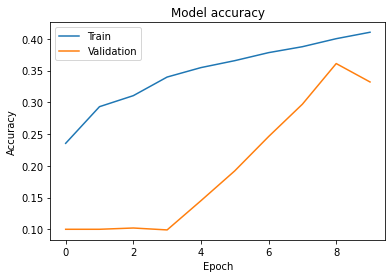

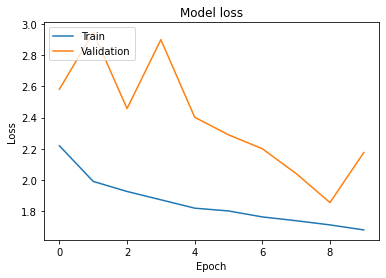

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: yd6yd0ew with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: True
wandb: 	dropout: 0.1
wandb: 	fc_layer: 128
wandb: 	num_filters: [64, 128, 256, 512, 1024]
wandb: 	shape_of_filters_conv: [[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_True_drop_0.1_fc_128_fil_[64, 128, 256, 512, 1024]_shape_[[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
8515850
Epoch 1/10
70/70 - 214s - loss: 2.2643 - accuracy: 0.2172 - val_loss: 2.3826 - val_accuracy: 0.1000
Epoch 2/10
70/70 - 211s - loss: 2.0724 - accuracy: 0.2584 - val_loss: 2.6554 - val_accuracy: 0.1000
Epoch 3/10
70/70 - 214s - loss: 2.0450 - accuracy: 0.2723 - val_loss: 2.6583 - val_accuracy: 0.1220
Epoch 4/10
70/70 - 204s - loss: 2.0047 - accuracy: 0.2856 - val_loss: 2.7718 - val_accuracy: 0.1040
Epoch 5/10
70/70 - 204s - loss: 1.9698 - accuracy: 0.2992 - val_loss: 2.6348 - val_accuracy: 0.1260
Epoch 6/10
70/70 - 208s - loss: 1.9588 - accuracy: 0.3032 - val_loss: 2.2351 - val_accuracy: 0.1910
Epoch 7/10
70/70 - 209s - loss: 1.9321 - accuracy: 0.3111 - val_loss: 2.1883 - val_accuracy: 0.2430
Epoch 8/10
70/70 - 213s - loss: 1.9175 - accur

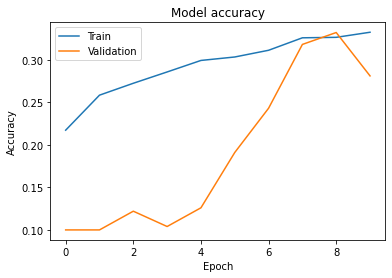

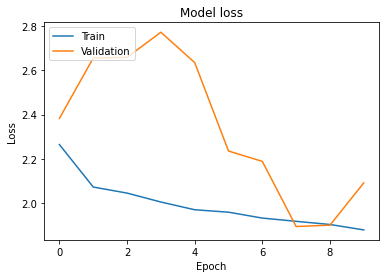

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3p2280vx with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0
wandb: 	fc_layer: 256
wandb: 	num_filters: [128, 64, 32, 16, 8]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_False_drop_0_fc_256_fil_[128, 64, 32, 16, 8]_shape_[[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
155650
Epoch 1/10
70/70 - 199s - loss: 2.3016 - accuracy: 0.1034 - val_loss: 2.2985 - val_accuracy: 0.1180
Epoch 2/10
70/70 - 198s - loss: 2.2874 - accuracy: 0.1303 - val_loss: 2.2721 - val_accuracy: 0.1340
Epoch 3/10
70/70 - 198s - loss: 2.2371 - accuracy: 0.1675 - val_loss: 2.2370 - val_accuracy: 0.1770
Epoch 4/10
70/70 - 191s - loss: 2.1939 - accuracy: 0.1938 - val_loss: 2.1696 - val_accuracy: 0.1980
Epoch 5/10
70/70 - 191s - loss: 2.1624 - accuracy: 0.2098 - val_loss: 2.1152 - val_accuracy: 0.2430
Epoch 6/10
70/70 - 197s - loss: 2.1158 - accuracy: 0.2377 - val_loss: 2.1240 - val_accuracy: 0.2380
Epoch 7/10
70/70 - 196s - loss: 2.0893 - accuracy: 0.2521 - val_loss: 2.0982 - val_accuracy: 0.2430
Epoch 8/10
70/70 - 199s - loss: 2.0694 - accuracy: 0.

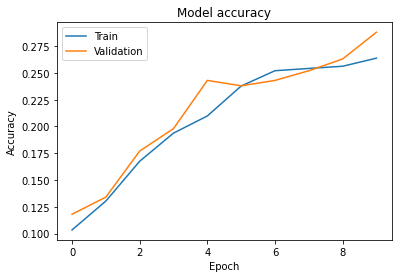

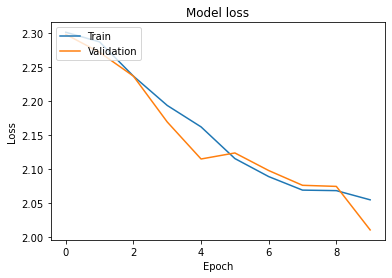

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fqx93kg3 with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0.1
wandb: 	fc_layer: 256
wandb: 	num_filters: [64, 128, 256, 512, 1024]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_False_drop_0.1_fc_256_fil_[64, 128, 256, 512, 1024]_shape_[[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
30390666
Epoch 1/10
70/70 - 213s - loss: 2.2431 - accuracy: 0.1602 - val_loss: 2.1784 - val_accuracy: 0.1970
Epoch 2/10
70/70 - 198s - loss: 2.1520 - accuracy: 0.2055 - val_loss: 2.1306 - val_accuracy: 0.2310
Epoch 3/10
70/70 - 199s - loss: 2.1051 - accuracy: 0.2322 - val_loss: 2.0973 - val_accuracy: 0.2430
Epoch 4/10
70/70 - 199s - loss: 2.0731 - accuracy: 0.2598 - val_loss: 2.0833 - val_accuracy: 0.2550
Epoch 5/10
70/70 - 194s - loss: 2.0284 - accuracy: 0.2770 - val_loss: 2.0093 - val_accuracy: 0.2960
Epoch 6/10
70/70 - 200s - loss: 1.9984 - accuracy: 0.2899 - val_loss: 1.9441 - val_accuracy: 0.3240
Epoch 7/10
70/70 - 203s - loss: 1.9731 - accuracy: 0.3042 - val_loss: 1.9543 - val_accuracy: 0.3230
Epoch 8/10
70/70 - 211s - loss: 1.9437 - acc

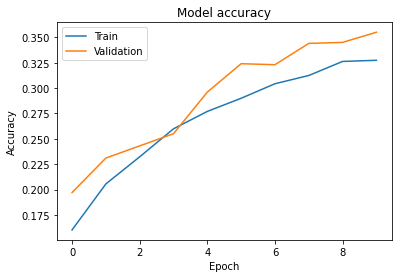

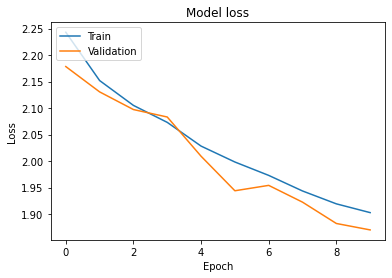

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: xba5a23q with config:
wandb: 	batch_norm_use: False
wandb: 	data_aug: True
wandb: 	dropout: 0.1
wandb: 	fc_layer: 256
wandb: 	num_filters: [128, 64, 32, 16, 8]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_False_drop_0.1_fc_256_fil_[128, 64, 32, 16, 8]_shape_[[3, 3], [3, 3], [3, 3], [5, 5], [7, 7]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
125954
Epoch 1/10
70/70 - 213s - loss: 2.3021 - accuracy: 0.1065 - val_loss: 2.2998 - val_accuracy: 0.1250
Epoch 2/10
70/70 - 206s - loss: 2.2769 - accuracy: 0.1445 - val_loss: 2.2371 - val_accuracy: 0.1720
Epoch 3/10
70/70 - 203s - loss: 2.2129 - accuracy: 0.1750 - val_loss: 2.1842 - val_accuracy: 0.1960
Epoch 4/10
70/70 - 197s - loss: 2.1773 - accuracy: 0.1895 - val_loss: 2.1700 - val_accuracy: 0.2010
Epoch 5/10
70/70 - 202s - loss: 2.1651 - accuracy: 0.1969 - val_loss: 2.1741 - val_accuracy: 0.1900
Epoch 6/10
70/70 - 198s - loss: 2.1592 - accuracy: 0.1964 - val_loss: 2.1634 - val_accuracy: 0.1950
Epoch 7/10
70/70 - 202s - loss: 2.1492 - accuracy: 0.2027 - val_loss: 2.1705 - val_accuracy: 0.2000
Epoch 8/10
70/70 - 199s - loss: 2.1418 - accuracy: 

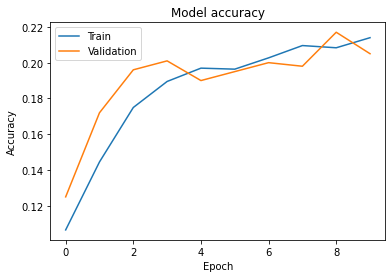

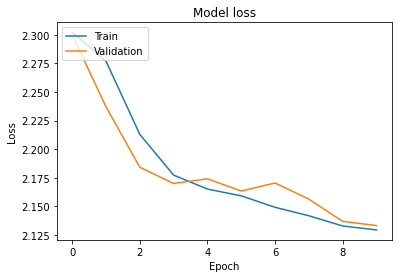

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 11yg6wmd with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: True
wandb: 	dropout: 0.1
wandb: 	fc_layer: 256
wandb: 	num_filters: [64, 128, 256, 512, 1024]
wandb: 	shape_of_filters_conv: [[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_True_drop_0.1_fc_256_fil_[64, 128, 256, 512, 1024]_shape_[[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
10614410
Epoch 1/10
70/70 - 217s - loss: 2.3340 - accuracy: 0.2098 - val_loss: 2.3537 - val_accuracy: 0.1010
Epoch 2/10
70/70 - 208s - loss: 2.0592 - accuracy: 0.2673 - val_loss: 2.5506 - val_accuracy: 0.1100
Epoch 3/10
70/70 - 209s - loss: 2.0158 - accuracy: 0.2840 - val_loss: 2.5468 - val_accuracy: 0.1060
Epoch 4/10
70/70 - 203s - loss: 1.9837 - accuracy: 0.2994 - val_loss: 2.5484 - val_accuracy: 0.1020
Epoch 5/10
70/70 - 207s - loss: 1.9475 - accuracy: 0.3075 - val_loss: 2.4086 - val_accuracy: 0.1360
Epoch 6/10
70/70 - 209s - loss: 1.9299 - accuracy: 0.3160 - val_loss: 2.1557 - val_accuracy: 0.1970
Epoch 7/10
70/70 - 208s - loss: 1.9004 - accuracy: 0.3281 - val_loss: 2.0467 - val_accuracy: 0.2700
Epoch 8/10
70/70 - 211s - loss: 1.8856 - accu

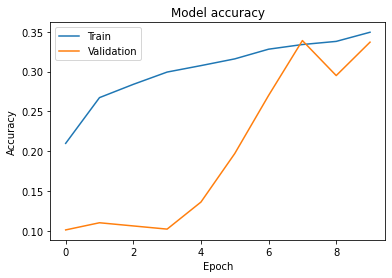

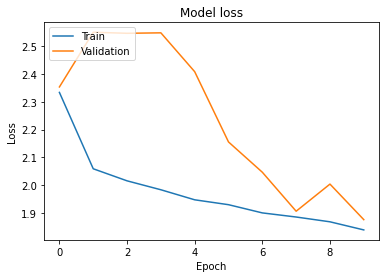

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: jstcxcko with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: True
wandb: 	dropout: 0.2
wandb: 	fc_layer: 512
wandb: 	num_filters: [64, 128, 256, 512, 1024]
wandb: 	shape_of_filters_conv: [[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_True_drop_0.2_fc_512_fil_[64, 128, 256, 512, 1024]_shape_[[7, 7], [5, 5], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
14811530
Epoch 1/10
70/70 - 213s - loss: 2.4859 - accuracy: 0.2012 - val_loss: 2.3877 - val_accuracy: 0.1000
Epoch 2/10
70/70 - 210s - loss: 2.0716 - accuracy: 0.2586 - val_loss: 2.4862 - val_accuracy: 0.1250
Epoch 3/10
70/70 - 214s - loss: 2.0311 - accuracy: 0.2779 - val_loss: 2.6440 - val_accuracy: 0.1000
Epoch 4/10
70/70 - 212s - loss: 2.0031 - accuracy: 0.2913 - val_loss: 2.5399 - val_accuracy: 0.1050
Epoch 5/10
70/70 - 204s - loss: 1.9610 - accuracy: 0.3085 - val_loss: 2.3516 - val_accuracy: 0.1260
Epoch 6/10
70/70 - 208s - loss: 1.9522 - accuracy: 0.3072 - val_loss: 2.2480 - val_accuracy: 0.1790
Epoch 7/10
70/70 - 212s - loss: 1.9241 - accuracy: 0.3182 - val_loss: 2.0302 - val_accuracy: 0.2570
Epoch 8/10
70/70 - 215s - loss: 1.8923 - accu

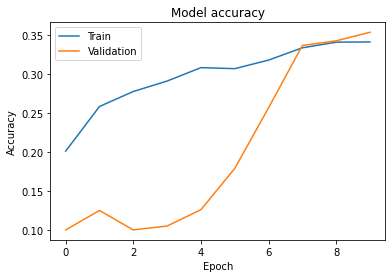

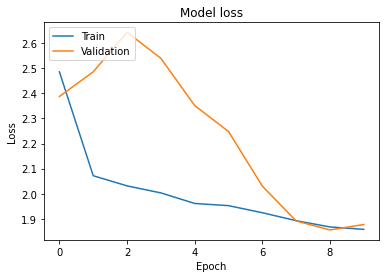

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: p0bvt09q with config:
wandb: 	batch_norm_use: True
wandb: 	data_aug: True
wandb: 	dropout: 0.1
wandb: 	fc_layer: 512
wandb: 	num_filters: [32, 64, 128, 256, 512]
wandb: 	shape_of_filters_conv: [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
wandb: 	train_batch_size: 128


aug_True_bs_128_bn_True_drop_0.1_fc_512_fil_[32, 64, 128, 256, 512]_shape_[[3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
8131786
Epoch 1/10
70/70 - 215s - loss: 2.3326 - accuracy: 0.2076 - val_loss: 2.3637 - val_accuracy: 0.1000
Epoch 2/10
70/70 - 213s - loss: 2.0254 - accuracy: 0.2805 - val_loss: 2.5821 - val_accuracy: 0.1000
Epoch 3/10
70/70 - 216s - loss: 1.9729 - accuracy: 0.3035 - val_loss: 2.4437 - val_accuracy: 0.1150
Epoch 4/10


In [ ]:
sweep_config = {
  "name": "Sweep 2 CS6910 Assignment 2 - Part A",
  "metric": {
      "name":"val_accuracy",
      "goal": "maximize"
  },
  "method": "random",
  "parameters": {
        "data_aug": {
            "values": [True]
        },
        "train_batch_size": {
            "values": [128]
        },
        "batch_norm_use": {
            "values": [True, False]
        },
        "dropout": {
            "values": [0, 0.2, 0.1]
        },
        "num_filters": {
            "values": [[32, 64, 128, 256, 512],
                       [128, 64, 32, 16, 8], [64, 128, 256, 512, 1024]]
        },
        "fc_layer": {
            "values": [128, 256, 512]
        },
        "shape_of_filters_conv": {
            "values": [[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3)],
                       [(7, 7), (5, 5), (3, 3), (3, 3), (3, 3)],
                       [(3, 3), (3, 3), (3, 3), (5, 5), (7, 7)]]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, entity="ee17b154tony", project="dl_assignment_2")
wandb.agent(sweep_id, train_validate_model_wandb, count=25)